In [1]:
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

torch.manual_seed(142)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Supported Device: ", DEVICE)

Supported Device:  cuda


In [2]:
#!pip install polars

In [3]:
y = torch.rand(8, 384)
y_pred = torch.rand(8, 384)

In [4]:

nn.Softmax()(((y - y_pred) ** 2).mean(1)).view(-1,1) * ((y - y_pred) ** 2)

E:\PycharmProjects\birdclef24\venv\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[5.8964e-05, 2.9042e-03, 6.2577e-02,  ..., 1.1371e-02, 2.0830e-02,
         8.7300e-04],
        [1.3232e-02, 1.2593e-03, 1.1460e-05,  ..., 1.1621e-04, 8.1758e-02,
         5.0281e-04],
        [1.2976e-03, 2.2317e-03, 2.3386e-03,  ..., 5.2718e-03, 1.1645e-03,
         3.9252e-03],
        ...,
        [1.3275e-02, 1.0641e-03, 1.2020e-02,  ..., 9.9086e-02, 6.2656e-03,
         8.4293e-05],
        [9.6871e-05, 3.4121e-03, 4.2281e-02,  ..., 1.8872e-03, 5.2174e-03,
         8.5696e-02],
        [1.9085e-02, 3.8792e-02, 7.0058e-02,  ..., 9.8728e-03, 5.3539e-02,
         1.5138e-02]])

In [5]:
# EXT_SRC: It contains 1 million randomly selected and shuffled rows from the original dataset.


TRAIN_PATH = "train_data_sample_1kk.parquet"
TRAIN_PATH = "train_sampled_1m.parquet"
TRAIN_PATH = "train_data_sample_3kk_part_1.parquet"
TRAIN_PATH = "train_data_sample_3kk_part_2.parquet"

NUM_EPOCHS = 30
BATCH_SIZE = 256
LEARNING_RATE = 1e-4
ERR = 1e-16

TRAIN_SIZE = 800000
VALID_SIZE = 200000

TRAIN_SIZE = 1_250_000
VALID_SIZE = 250_000

DIM_FEATURES = 556
DIM_TARGETS = 368

In [6]:
ID = "sample_id"

# INPUT COLUMNS

STATE_PS = "state_ps"

PBUF_SOLIN = "pbuf_SOLIN"
PBUF_LHFLX = "pbuf_LHFLX"
PBUF_SHFLX = "pbuf_SHFLX"
PBUF_TAUX = "pbuf_TAUX"
PBUF_TAUY = "pbuf_TAUY"
PBUF_COSZRS = "pbuf_COSZRS"

CAM_IN_ALDIF = "cam_in_ALDIF"
CAM_IN_ALDIR = "cam_in_ALDIR"
CAM_IN_ASDIF = "cam_in_ASDIF"
CAM_IN_ASDIR = "cam_in_ASDIR"
CAM_IN_LWUP = "cam_in_LWUP"
CAM_IN_ICEFRAC = "cam_in_ICEFRAC"
CAM_IN_LANDFRAC = "cam_in_LANDFRAC"
CAM_IN_OCNFRAC = "cam_in_OCNFRAC"
CAM_IN_SNOWHLAND = "cam_in_SNOWHLAND"

STATE_U = ['state_u_0', 'state_u_1', 'state_u_2', 'state_u_3', 'state_u_4', 'state_u_5', 'state_u_6', 'state_u_7', 'state_u_8', 'state_u_9', 'state_u_10', 'state_u_11', 'state_u_12', 'state_u_13', 'state_u_14', 'state_u_15', 'state_u_16', 'state_u_17', 'state_u_18', 'state_u_19', 'state_u_20', 'state_u_21', 'state_u_22', 'state_u_23', 'state_u_24', 'state_u_25', 'state_u_26', 'state_u_27', 'state_u_28', 'state_u_29', 'state_u_30', 'state_u_31', 'state_u_32', 'state_u_33', 'state_u_34', 'state_u_35', 'state_u_36', 'state_u_37', 'state_u_38', 'state_u_39', 'state_u_40', 'state_u_41', 'state_u_42', 'state_u_43', 'state_u_44', 'state_u_45', 'state_u_46', 'state_u_47', 'state_u_48', 'state_u_49', 'state_u_50', 'state_u_51', 'state_u_52', 'state_u_53', 'state_u_54', 'state_u_55', 'state_u_56', 'state_u_57', 'state_u_58', 'state_u_59']
STATE_V = ['state_v_0', 'state_v_1', 'state_v_2', 'state_v_3', 'state_v_4', 'state_v_5', 'state_v_6', 'state_v_7', 'state_v_8', 'state_v_9', 'state_v_10', 'state_v_11', 'state_v_12', 'state_v_13', 'state_v_14', 'state_v_15', 'state_v_16', 'state_v_17', 'state_v_18', 'state_v_19', 'state_v_20', 'state_v_21', 'state_v_22', 'state_v_23', 'state_v_24', 'state_v_25', 'state_v_26', 'state_v_27', 'state_v_28', 'state_v_29', 'state_v_30', 'state_v_31', 'state_v_32', 'state_v_33', 'state_v_34', 'state_v_35', 'state_v_36', 'state_v_37', 'state_v_38', 'state_v_39', 'state_v_40', 'state_v_41', 'state_v_42', 'state_v_43', 'state_v_44', 'state_v_45', 'state_v_46', 'state_v_47', 'state_v_48', 'state_v_49', 'state_v_50', 'state_v_51', 'state_v_52', 'state_v_53', 'state_v_54', 'state_v_55', 'state_v_56', 'state_v_57', 'state_v_58', 'state_v_59']
STATE_T = ['state_t_0', 'state_t_1', 'state_t_2', 'state_t_3', 'state_t_4', 'state_t_5', 'state_t_6', 'state_t_7', 'state_t_8', 'state_t_9', 'state_t_10', 'state_t_11', 'state_t_12', 'state_t_13', 'state_t_14', 'state_t_15', 'state_t_16', 'state_t_17', 'state_t_18', 'state_t_19', 'state_t_20', 'state_t_21', 'state_t_22', 'state_t_23', 'state_t_24', 'state_t_25', 'state_t_26', 'state_t_27', 'state_t_28', 'state_t_29', 'state_t_30', 'state_t_31', 'state_t_32', 'state_t_33', 'state_t_34', 'state_t_35', 'state_t_36', 'state_t_37', 'state_t_38', 'state_t_39', 'state_t_40', 'state_t_41', 'state_t_42', 'state_t_43', 'state_t_44', 'state_t_45', 'state_t_46', 'state_t_47', 'state_t_48', 'state_t_49', 'state_t_50', 'state_t_51', 'state_t_52', 'state_t_53', 'state_t_54', 'state_t_55', 'state_t_56', 'state_t_57', 'state_t_58', 'state_t_59']

STATE_Q0001 = ['state_q0001_0', 'state_q0001_1', 'state_q0001_2', 'state_q0001_3', 'state_q0001_4', 'state_q0001_5', 'state_q0001_6', 'state_q0001_7', 'state_q0001_8', 'state_q0001_9', 'state_q0001_10', 'state_q0001_11', 'state_q0001_12', 'state_q0001_13', 'state_q0001_14', 'state_q0001_15', 'state_q0001_16', 'state_q0001_17', 'state_q0001_18', 'state_q0001_19', 'state_q0001_20', 'state_q0001_21', 'state_q0001_22', 'state_q0001_23', 'state_q0001_24', 'state_q0001_25', 'state_q0001_26', 'state_q0001_27', 'state_q0001_28', 'state_q0001_29', 'state_q0001_30', 'state_q0001_31', 'state_q0001_32', 'state_q0001_33', 'state_q0001_34', 'state_q0001_35', 'state_q0001_36', 'state_q0001_37', 'state_q0001_38', 'state_q0001_39', 'state_q0001_40', 'state_q0001_41', 'state_q0001_42', 'state_q0001_43', 'state_q0001_44', 'state_q0001_45', 'state_q0001_46', 'state_q0001_47', 'state_q0001_48', 'state_q0001_49', 'state_q0001_50', 'state_q0001_51', 'state_q0001_52', 'state_q0001_53', 'state_q0001_54', 'state_q0001_55', 'state_q0001_56', 'state_q0001_57', 'state_q0001_58', 'state_q0001_59']
STATE_Q0002 = ['state_q0002_0', 'state_q0002_1', 'state_q0002_2', 'state_q0002_3', 'state_q0002_4', 'state_q0002_5', 'state_q0002_6', 'state_q0002_7', 'state_q0002_8', 'state_q0002_9', 'state_q0002_10', 'state_q0002_11', 'state_q0002_12', 'state_q0002_13', 'state_q0002_14', 'state_q0002_15', 'state_q0002_16', 'state_q0002_17', 'state_q0002_18', 'state_q0002_19', 'state_q0002_20', 'state_q0002_21', 'state_q0002_22', 'state_q0002_23', 'state_q0002_24', 'state_q0002_25', 'state_q0002_26', 'state_q0002_27', 'state_q0002_28', 'state_q0002_29', 'state_q0002_30', 'state_q0002_31', 'state_q0002_32', 'state_q0002_33', 'state_q0002_34', 'state_q0002_35', 'state_q0002_36', 'state_q0002_37', 'state_q0002_38', 'state_q0002_39', 'state_q0002_40', 'state_q0002_41', 'state_q0002_42', 'state_q0002_43', 'state_q0002_44', 'state_q0002_45', 'state_q0002_46', 'state_q0002_47', 'state_q0002_48', 'state_q0002_49', 'state_q0002_50', 'state_q0002_51', 'state_q0002_52', 'state_q0002_53', 'state_q0002_54', 'state_q0002_55', 'state_q0002_56', 'state_q0002_57', 'state_q0002_58', 'state_q0002_59']
STATE_Q0003 = ['state_q0003_0', 'state_q0003_1', 'state_q0003_2', 'state_q0003_3', 'state_q0003_4', 'state_q0003_5', 'state_q0003_6', 'state_q0003_7', 'state_q0003_8', 'state_q0003_9', 'state_q0003_10', 'state_q0003_11', 'state_q0003_12', 'state_q0003_13', 'state_q0003_14', 'state_q0003_15', 'state_q0003_16', 'state_q0003_17', 'state_q0003_18', 'state_q0003_19', 'state_q0003_20', 'state_q0003_21', 'state_q0003_22', 'state_q0003_23', 'state_q0003_24', 'state_q0003_25', 'state_q0003_26', 'state_q0003_27', 'state_q0003_28', 'state_q0003_29', 'state_q0003_30', 'state_q0003_31', 'state_q0003_32', 'state_q0003_33', 'state_q0003_34', 'state_q0003_35', 'state_q0003_36', 'state_q0003_37', 'state_q0003_38', 'state_q0003_39', 'state_q0003_40', 'state_q0003_41', 'state_q0003_42', 'state_q0003_43', 'state_q0003_44', 'state_q0003_45', 'state_q0003_46', 'state_q0003_47', 'state_q0003_48', 'state_q0003_49', 'state_q0003_50', 'state_q0003_51', 'state_q0003_52', 'state_q0003_53', 'state_q0003_54', 'state_q0003_55', 'state_q0003_56', 'state_q0003_57', 'state_q0003_58', 'state_q0003_59']

PBUF_OZONE = ['pbuf_ozone_0', 'pbuf_ozone_1', 'pbuf_ozone_2', 'pbuf_ozone_3', 'pbuf_ozone_4', 'pbuf_ozone_5', 'pbuf_ozone_6', 'pbuf_ozone_7', 'pbuf_ozone_8', 'pbuf_ozone_9', 'pbuf_ozone_10', 'pbuf_ozone_11', 'pbuf_ozone_12', 'pbuf_ozone_13', 'pbuf_ozone_14', 'pbuf_ozone_15', 'pbuf_ozone_16', 'pbuf_ozone_17', 'pbuf_ozone_18', 'pbuf_ozone_19', 'pbuf_ozone_20', 'pbuf_ozone_21', 'pbuf_ozone_22', 'pbuf_ozone_23', 'pbuf_ozone_24', 'pbuf_ozone_25', 'pbuf_ozone_26', 'pbuf_ozone_27', 'pbuf_ozone_28', 'pbuf_ozone_29', 'pbuf_ozone_30', 'pbuf_ozone_31', 'pbuf_ozone_32', 'pbuf_ozone_33', 'pbuf_ozone_34', 'pbuf_ozone_35', 'pbuf_ozone_36', 'pbuf_ozone_37', 'pbuf_ozone_38', 'pbuf_ozone_39', 'pbuf_ozone_40', 'pbuf_ozone_41', 'pbuf_ozone_42', 'pbuf_ozone_43', 'pbuf_ozone_44', 'pbuf_ozone_45', 'pbuf_ozone_46', 'pbuf_ozone_47', 'pbuf_ozone_48', 'pbuf_ozone_49', 'pbuf_ozone_50', 'pbuf_ozone_51', 'pbuf_ozone_52', 'pbuf_ozone_53', 'pbuf_ozone_54', 'pbuf_ozone_55', 'pbuf_ozone_56', 'pbuf_ozone_57', 'pbuf_ozone_58', 'pbuf_ozone_59']
PBUF_CH4 = ['pbuf_CH4_0', 'pbuf_CH4_1', 'pbuf_CH4_2', 'pbuf_CH4_3', 'pbuf_CH4_4', 'pbuf_CH4_5', 'pbuf_CH4_6', 'pbuf_CH4_7', 'pbuf_CH4_8', 'pbuf_CH4_9', 'pbuf_CH4_10', 'pbuf_CH4_11', 'pbuf_CH4_12', 'pbuf_CH4_13', 'pbuf_CH4_14', 'pbuf_CH4_15', 'pbuf_CH4_16', 'pbuf_CH4_17', 'pbuf_CH4_18', 'pbuf_CH4_19', 'pbuf_CH4_20', 'pbuf_CH4_21', 'pbuf_CH4_22', 'pbuf_CH4_23', 'pbuf_CH4_24', 'pbuf_CH4_25', 'pbuf_CH4_26', 'pbuf_CH4_27', 'pbuf_CH4_28', 'pbuf_CH4_29', 'pbuf_CH4_30', 'pbuf_CH4_31', 'pbuf_CH4_32', 'pbuf_CH4_33', 'pbuf_CH4_34', 'pbuf_CH4_35', 'pbuf_CH4_36', 'pbuf_CH4_37', 'pbuf_CH4_38', 'pbuf_CH4_39', 'pbuf_CH4_40', 'pbuf_CH4_41', 'pbuf_CH4_42', 'pbuf_CH4_43', 'pbuf_CH4_44', 'pbuf_CH4_45', 'pbuf_CH4_46', 'pbuf_CH4_47', 'pbuf_CH4_48', 'pbuf_CH4_49', 'pbuf_CH4_50', 'pbuf_CH4_51', 'pbuf_CH4_52', 'pbuf_CH4_53', 'pbuf_CH4_54', 'pbuf_CH4_55', 'pbuf_CH4_56', 'pbuf_CH4_57', 'pbuf_CH4_58', 'pbuf_CH4_59']
PBUF_N2O = ['pbuf_N2O_0', 'pbuf_N2O_1', 'pbuf_N2O_2', 'pbuf_N2O_3', 'pbuf_N2O_4', 'pbuf_N2O_5', 'pbuf_N2O_6', 'pbuf_N2O_7', 'pbuf_N2O_8', 'pbuf_N2O_9', 'pbuf_N2O_10', 'pbuf_N2O_11', 'pbuf_N2O_12', 'pbuf_N2O_13', 'pbuf_N2O_14', 'pbuf_N2O_15', 'pbuf_N2O_16', 'pbuf_N2O_17', 'pbuf_N2O_18', 'pbuf_N2O_19', 'pbuf_N2O_20', 'pbuf_N2O_21', 'pbuf_N2O_22', 'pbuf_N2O_23', 'pbuf_N2O_24', 'pbuf_N2O_25', 'pbuf_N2O_26', 'pbuf_N2O_27', 'pbuf_N2O_28', 'pbuf_N2O_29', 'pbuf_N2O_30', 'pbuf_N2O_31', 'pbuf_N2O_32', 'pbuf_N2O_33', 'pbuf_N2O_34', 'pbuf_N2O_35', 'pbuf_N2O_36', 'pbuf_N2O_37', 'pbuf_N2O_38', 'pbuf_N2O_39', 'pbuf_N2O_40', 'pbuf_N2O_41', 'pbuf_N2O_42', 'pbuf_N2O_43', 'pbuf_N2O_44', 'pbuf_N2O_45', 'pbuf_N2O_46', 'pbuf_N2O_47', 'pbuf_N2O_48', 'pbuf_N2O_49', 'pbuf_N2O_50', 'pbuf_N2O_51', 'pbuf_N2O_52', 'pbuf_N2O_53', 'pbuf_N2O_54', 'pbuf_N2O_55', 'pbuf_N2O_56', 'pbuf_N2O_57', 'pbuf_N2O_58', 'pbuf_N2O_59']

# OUTPUT COLUMNS

CAM_OUT_NETSW = "cam_out_NETSW"
CAM_OUT_FLWDS = "cam_out_FLWDS"
CAM_OUT_PRECSC = "cam_out_PRECSC"
CAM_OUT_PRECC = "cam_out_PRECC"
CAM_OUT_SOLS = "cam_out_SOLS"
CAM_OUT_SOLL = "cam_out_SOLL"
CAM_OUT_SOLSD = "cam_out_SOLSD"
CAM_OUT_SOLLD = "cam_out_SOLLD"

PTEND_Q0001 = ['ptend_q0001_0', 'ptend_q0001_1', 'ptend_q0001_2', 'ptend_q0001_3', 'ptend_q0001_4', 'ptend_q0001_5', 'ptend_q0001_6', 'ptend_q0001_7', 'ptend_q0001_8', 'ptend_q0001_9', 'ptend_q0001_10', 'ptend_q0001_11', 'ptend_q0001_12', 'ptend_q0001_13', 'ptend_q0001_14', 'ptend_q0001_15', 'ptend_q0001_16', 'ptend_q0001_17', 'ptend_q0001_18', 'ptend_q0001_19', 'ptend_q0001_20', 'ptend_q0001_21', 'ptend_q0001_22', 'ptend_q0001_23', 'ptend_q0001_24', 'ptend_q0001_25', 'ptend_q0001_26', 'ptend_q0001_27', 'ptend_q0001_28', 'ptend_q0001_29', 'ptend_q0001_30', 'ptend_q0001_31', 'ptend_q0001_32', 'ptend_q0001_33', 'ptend_q0001_34', 'ptend_q0001_35', 'ptend_q0001_36', 'ptend_q0001_37', 'ptend_q0001_38', 'ptend_q0001_39', 'ptend_q0001_40', 'ptend_q0001_41', 'ptend_q0001_42', 'ptend_q0001_43', 'ptend_q0001_44', 'ptend_q0001_45', 'ptend_q0001_46', 'ptend_q0001_47', 'ptend_q0001_48', 'ptend_q0001_49', 'ptend_q0001_50', 'ptend_q0001_51', 'ptend_q0001_52', 'ptend_q0001_53', 'ptend_q0001_54', 'ptend_q0001_55', 'ptend_q0001_56', 'ptend_q0001_57', 'ptend_q0001_58', 'ptend_q0001_59']
PTEND_Q0002 = ['ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26', 'ptend_q0002_27', 'ptend_q0002_28', 'ptend_q0002_29', 'ptend_q0002_30', 'ptend_q0002_31', 'ptend_q0002_32', 'ptend_q0002_33', 'ptend_q0002_34', 'ptend_q0002_35', 'ptend_q0002_36', 'ptend_q0002_37', 'ptend_q0002_38', 'ptend_q0002_39', 'ptend_q0002_40', 'ptend_q0002_41', 'ptend_q0002_42', 'ptend_q0002_43', 'ptend_q0002_44', 'ptend_q0002_45', 'ptend_q0002_46', 'ptend_q0002_47', 'ptend_q0002_48', 'ptend_q0002_49', 'ptend_q0002_50', 'ptend_q0002_51', 'ptend_q0002_52', 'ptend_q0002_53', 'ptend_q0002_54', 'ptend_q0002_55', 'ptend_q0002_56', 'ptend_q0002_57', 'ptend_q0002_58', 'ptend_q0002_59']
PTEND_Q0003 = ['ptend_q0003_0', 'ptend_q0003_1', 'ptend_q0003_2', 'ptend_q0003_3', 'ptend_q0003_4', 'ptend_q0003_5', 'ptend_q0003_6', 'ptend_q0003_7', 'ptend_q0003_8', 'ptend_q0003_9', 'ptend_q0003_10', 'ptend_q0003_11', 'ptend_q0003_12', 'ptend_q0003_13', 'ptend_q0003_14', 'ptend_q0003_15', 'ptend_q0003_16', 'ptend_q0003_17', 'ptend_q0003_18', 'ptend_q0003_19', 'ptend_q0003_20', 'ptend_q0003_21', 'ptend_q0003_22', 'ptend_q0003_23', 'ptend_q0003_24', 'ptend_q0003_25', 'ptend_q0003_26', 'ptend_q0003_27', 'ptend_q0003_28', 'ptend_q0003_29', 'ptend_q0003_30', 'ptend_q0003_31', 'ptend_q0003_32', 'ptend_q0003_33', 'ptend_q0003_34', 'ptend_q0003_35', 'ptend_q0003_36', 'ptend_q0003_37', 'ptend_q0003_38', 'ptend_q0003_39', 'ptend_q0003_40', 'ptend_q0003_41', 'ptend_q0003_42', 'ptend_q0003_43', 'ptend_q0003_44', 'ptend_q0003_45', 'ptend_q0003_46', 'ptend_q0003_47', 'ptend_q0003_48', 'ptend_q0003_49', 'ptend_q0003_50', 'ptend_q0003_51', 'ptend_q0003_52', 'ptend_q0003_53', 'ptend_q0003_54', 'ptend_q0003_55', 'ptend_q0003_56', 'ptend_q0003_57', 'ptend_q0003_58', 'ptend_q0003_59']

PTEND_U = ['ptend_u_0', 'ptend_u_1', 'ptend_u_2', 'ptend_u_3', 'ptend_u_4', 'ptend_u_5', 'ptend_u_6', 'ptend_u_7', 'ptend_u_8', 'ptend_u_9', 'ptend_u_10', 'ptend_u_11', 'ptend_u_12', 'ptend_u_13', 'ptend_u_14', 'ptend_u_15', 'ptend_u_16', 'ptend_u_17', 'ptend_u_18', 'ptend_u_19', 'ptend_u_20', 'ptend_u_21', 'ptend_u_22', 'ptend_u_23', 'ptend_u_24', 'ptend_u_25', 'ptend_u_26', 'ptend_u_27', 'ptend_u_28', 'ptend_u_29', 'ptend_u_30', 'ptend_u_31', 'ptend_u_32', 'ptend_u_33', 'ptend_u_34', 'ptend_u_35', 'ptend_u_36', 'ptend_u_37', 'ptend_u_38', 'ptend_u_39', 'ptend_u_40', 'ptend_u_41', 'ptend_u_42', 'ptend_u_43', 'ptend_u_44', 'ptend_u_45', 'ptend_u_46', 'ptend_u_47', 'ptend_u_48', 'ptend_u_49', 'ptend_u_50', 'ptend_u_51', 'ptend_u_52', 'ptend_u_53', 'ptend_u_54', 'ptend_u_55', 'ptend_u_56', 'ptend_u_57', 'ptend_u_58', 'ptend_u_59']
PTEND_V = ['ptend_v_0', 'ptend_v_1', 'ptend_v_2', 'ptend_v_3', 'ptend_v_4', 'ptend_v_5', 'ptend_v_6', 'ptend_v_7', 'ptend_v_8', 'ptend_v_9', 'ptend_v_10', 'ptend_v_11', 'ptend_v_12', 'ptend_v_13', 'ptend_v_14', 'ptend_v_15', 'ptend_v_16', 'ptend_v_17', 'ptend_v_18', 'ptend_v_19', 'ptend_v_20', 'ptend_v_21', 'ptend_v_22', 'ptend_v_23', 'ptend_v_24', 'ptend_v_25', 'ptend_v_26', 'ptend_v_27', 'ptend_v_28', 'ptend_v_29', 'ptend_v_30', 'ptend_v_31', 'ptend_v_32', 'ptend_v_33', 'ptend_v_34', 'ptend_v_35', 'ptend_v_36', 'ptend_v_37', 'ptend_v_38', 'ptend_v_39', 'ptend_v_40', 'ptend_v_41', 'ptend_v_42', 'ptend_v_43', 'ptend_v_44', 'ptend_v_45', 'ptend_v_46', 'ptend_v_47', 'ptend_v_48', 'ptend_v_49', 'ptend_v_50', 'ptend_v_51', 'ptend_v_52', 'ptend_v_53', 'ptend_v_54', 'ptend_v_55', 'ptend_v_56', 'ptend_v_57', 'ptend_v_58', 'ptend_v_59']
PTEND_T = ['ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4', 'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8', 'ptend_t_9', 'ptend_t_10', 'ptend_t_11', 'ptend_t_12', 'ptend_t_13', 'ptend_t_14', 'ptend_t_15', 'ptend_t_16', 'ptend_t_17', 'ptend_t_18', 'ptend_t_19', 'ptend_t_20', 'ptend_t_21', 'ptend_t_22', 'ptend_t_23', 'ptend_t_24', 'ptend_t_25', 'ptend_t_26', 'ptend_t_27', 'ptend_t_28', 'ptend_t_29', 'ptend_t_30', 'ptend_t_31', 'ptend_t_32', 'ptend_t_33', 'ptend_t_34', 'ptend_t_35', 'ptend_t_36', 'ptend_t_37', 'ptend_t_38', 'ptend_t_39', 'ptend_t_40', 'ptend_t_41', 'ptend_t_42', 'ptend_t_43', 'ptend_t_44', 'ptend_t_45', 'ptend_t_46', 'ptend_t_47', 'ptend_t_48', 'ptend_t_49', 'ptend_t_50', 'ptend_t_51', 'ptend_t_52', 'ptend_t_53', 'ptend_t_54', 'ptend_t_55', 'ptend_t_56', 'ptend_t_57', 'ptend_t_58', 'ptend_t_59']

# REPLACEMENT COLUMNS

REPLACE_FROM = ['ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26']
REPLACE_TO = ['state_q0002_0', 'state_q0002_1', 'state_q0002_2', 'state_q0002_3', 'state_q0002_4', 'state_q0002_5', 'state_q0002_6', 'state_q0002_7', 'state_q0002_8', 'state_q0002_9', 'state_q0002_10', 'state_q0002_11', 'state_q0002_12', 'state_q0002_13', 'state_q0002_14', 'state_q0002_15', 'state_q0002_16', 'state_q0002_17', 'state_q0002_18', 'state_q0002_19', 'state_q0002_20', 'state_q0002_21', 'state_q0002_22', 'state_q0002_23', 'state_q0002_24', 'state_q0002_25', 'state_q0002_26']

# TARGET WEIGHTS

TARGET_WEIGHTS = [30981.265271661872, 22502.432413914863, 18894.14713004499, 14514.244730542465, 10944.348069459196, 9065.01072024503, 9663.669038687454, 12688.557362943708, 19890.17226527665, 25831.37317235381, 33890.367561807274, 44122.94111025334, 59811.25595068309, 79434.07500078829, 107358.80916894016, 135720.8418348218, 149399.8411114814, 128492.95185325432, 91746.23687305572, 72748.76911097553, 66531.53596840335, 62932.30598423903, 56610.26874314136, 49473.14369220607, 43029.18495420936, 36912.67491908133, 31486.93117928144, 26898.072997215502, 23316.638282978325, 20459.73133196152, 18385.68309639014, 17111.405107656312, 16337.80991958771, 15857.759882318944, 15580.902485189716, 15497.59045982052, 15612.2556996736, 15797.88455410361, 15974.218740897895, 16130.395527176632, 16261.310866446129, 16371.892401608216, 16397.019695140876, 16325.463899570548, 16228.641108112768, 16191.809643436269, 16341.207925934068, 16645.711351490587, 17005.493716683693, 17430.29874509864, 17907.24023203076, 18431.55334008694, 19032.471309392287, 19701.355113141435, 20408.236605392685, 20967.20795006453, 21194.427318009974, 21088.521528526755, 19437.91555757985, 13677.902713248171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 871528441401.8333, 1083221770553.0684, 147034752676.7702, 35556045575.13566, 35153369257.41337, 46086368691.51654, 24689305171.692936, 11343276593.440475, 5396624651.94418, 2449353007.641508, 1132225885.703891, 579547849.1340877, 330219246.7861086, 207613930.3131764, 144580292.27473342, 109933282.92266414, 88706603.092171, 73819777.54163922, 63615988.74519494, 57250262.292053565, 52976073.06761927, 49653169.17819005, 46544975.11484598, 43167606.9599748, 39724375.20499403, 36317177.25886468, 33057511.80930482, 29869089.497658804, 26982386.85583376, 24416235.17215712, 22273651.697369896, 20553426.04804544, 19216240.03357431, 18167694.44812838, 17501855.536957663, 17169938.630597908, 17005382.258644175, 16998475.26752617, 17082890.987979066, 17227982.77516062, 17445823.21630204, 17757404.421785507, 18346092.75160569, 19400573.66632694, 20506722.48296608, 22469648.380506545, 23432031.455169585, 26204163.40545158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 3673829810926.31, 371405570725.2526, 14219163611.984406, 3001863018.1934915, 1432766589.9326108, 884599805.0283787, 560127980.1033351, 386052567.7087711, 287331851.051439, 222703657.59538063, 181069239.6264349, 154620864.3164144, 138093777.60284117, 126605828.89875436, 117967840.02553518, 111005814.39518328, 105186901.20678852, 100168133.0295481, 95568646.67416307, 91457433.39515457, 88871610.45308323, 88829796.26374224, 91398113.73291488, 96585131.67000748, 104507692.01463065, 115895119.998433, 131939701.08213414, 154492946.00677127, 183147918.17086875, 215151374.22324687, 247158314.6345976, 266792879.42215955, 279115128.29108113, 370541510.87006927, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 877670509694.7871, 1174826943136.8308, 1270605570069.038, 21727315470.5208, 3159456646.5437946, 1090653401.282219, 727967089.8459107, 384399548.9506704, 290787296.9451616, 232703218.45048887, 197467462.7577736, 174310890.8025987, 160536437.73297343, 153567098.77048483, 152120124.9453068, 153115566.6756177, 153955545.42558223, 153734675.21565756, 154798666.36905554, 163346213.58113608, 180013139.3707387, 200324358.8534948, 220754613.1646765, 241290935.478592, 262868932.2066308, 284448910.01847774, 305681084.4142859, 327605088.8575117, 350473296.7263526, 373964594.1196182, 398396925.8173239, 423528355.65716046, 450447055.544388, 478857006.4973163, 508200335.7126168, 537309657.5789208, 566854568.2904652, 594618842.9455439, 619715928.2391286, 641395460.8414665, 663290039.7810476, 689274894.631561, 718208866.3397261, 743951200.8024124, 761776104.2945968, 772911224.3082078, 804001144.8046833, 772448774.7758856, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4613823.568205323, 1999308.9343799097, 904636.2296014762, 433823.6123842511, 207201.39055371704, 107836.09164720173, 57647.915219220784, 40606.52305039815, 47739.86647922776, 51669.35493930698, 56438.19768395407, 60447.45665200092, 65251.4153955275, 71920.88588011517, 78529.58115204438, 83422.30217897324, 87036.98552475807, 90389.72631774022, 93982.39165674087, 97578.0099352472, 101428.21366062944, 104630.69200130588, 105685.04322626138, 103962.58423268417, 99650.31670632094, 94290.49986206587, 89514.90144353417, 85905.45713126978, 82784.9857650212, 79152.28707014346, 74847.81017353121, 70378.81859610273, 65420.04643792357, 59953.75184604176, 54764.28281143022, 50362.51288353384, 46212.571031725325, 41997.52779088816, 37692.05148110484, 33834.73460995647, 31846.09764364542, 31934.145655397457, 31454.81247448105, 30105.4073072481, 26957.830283611693, 27760.04479210889, 29853.374336459365, 19133.428743715107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7619940.584531054, 3148394.472742347, 1308415.0022178134, 540515.7720745018, 215237.1053603881, 102546.7276372816, 68453.67122640925, 50692.59053608593, 51487.52043139844, 52104.76838400132, 54019.39151917722, 55856.02168787862, 60347.30240270209, 68990.96019017675, 79096.88768563846, 87574.33453690328, 94158.56052476274, 101903.63670531697, 111746.9753834774, 122460.65399236557, 132086.69387474353, 141041.48571028374, 146354.09441287292, 145953.09590059065, 139496.8007888401, 128508.85108217449, 116665.51769667884, 107458.39706309135, 100259.97236694951, 94108.98505029618, 88439.89456238014, 82734.9027659809, 77061.08621371102, 71333.5319243128, 65999.72532130677, 61798.9972058361, 58237.356419617165, 54715.10266341248, 50825.84431702935, 46059.17688689915, 40740.26050401376, 36335.80228304863, 33981.57568605091, 33589.7143390849, 33988.88524112733, 36272.9364507092, 41183.34413717943, 29194.12369278645, 0.0040536134869726, 0.0138824238058072, 135129884.5084534, 12219717.5342461, 0.0090705273332672, 0.0085898851680217, 0.0215368188774867, 0.0336321308942602]

SCALE_WEIGHTS = [1e10] * 360 + [1] * 8

TARGET_WEIGHTS = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


TARGET_WEIGHTS = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


SCALE_WEIGHTS = [100000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 100000.0, 100000.0, 1e+17, 1e+17, 1e+17, 1e+18, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 100000000000000.0, 100000000000000.0, 10000000000000.0, 10000000000000.0, 1000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e+41, 1e+47, 1e+52, 1e+55, 1e+50, 1e+47, 1e+44, 1e+42, 1e+39, 1e+36, 1e+33, 1e+30, 1e+27, 1e+23, 1e+18, 1000000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 1000000000000.0, 100000000000.0, 10000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000000000.0, 1e+16, 1000000000000000.0, 100000000000000.0, 10000000000000.0, 10000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 10000000.0, 1000000.0, 1000000.0, 10000000.0, 1000000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10000000000.0, 10000000000.0, 1000000000.0, 100000000.0, 1000000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 100000000.0, 100000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 1000000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 1000000.0, 10000000.0, 0.01, 0.001, 1000000000.0, 100000000.0, 0.01, 0.01, 0.01, 0.1]
SCALE_WEIGHTS = [min(w, 1e64) for w in SCALE_WEIGHTS]

#SCALE_WEIGHTS = [1e6] * 360 + [1] * 8


# FEATURE & TARGET LIST

FEATURE_NAMES = ['state_t_0', 'state_t_1', 'state_t_2', 'state_t_3', 'state_t_4', 'state_t_5', 'state_t_6', 'state_t_7', 'state_t_8', 'state_t_9', 'state_t_10', 'state_t_11', 'state_t_12', 'state_t_13', 'state_t_14', 'state_t_15', 'state_t_16', 'state_t_17', 'state_t_18', 'state_t_19', 'state_t_20', 'state_t_21', 'state_t_22', 'state_t_23', 'state_t_24', 'state_t_25', 'state_t_26', 'state_t_27', 'state_t_28', 'state_t_29', 'state_t_30', 'state_t_31', 'state_t_32', 'state_t_33', 'state_t_34', 'state_t_35', 'state_t_36', 'state_t_37', 'state_t_38', 'state_t_39', 'state_t_40', 'state_t_41', 'state_t_42', 'state_t_43', 'state_t_44', 'state_t_45', 'state_t_46', 'state_t_47', 'state_t_48', 'state_t_49', 'state_t_50', 'state_t_51', 'state_t_52', 'state_t_53', 'state_t_54', 'state_t_55', 'state_t_56', 'state_t_57', 'state_t_58', 'state_t_59', 'state_q0001_0', 'state_q0001_1', 'state_q0001_2', 'state_q0001_3', 'state_q0001_4', 'state_q0001_5', 'state_q0001_6', 'state_q0001_7', 'state_q0001_8', 'state_q0001_9', 'state_q0001_10', 'state_q0001_11', 'state_q0001_12', 'state_q0001_13', 'state_q0001_14', 'state_q0001_15', 'state_q0001_16', 'state_q0001_17', 'state_q0001_18', 'state_q0001_19', 'state_q0001_20', 'state_q0001_21', 'state_q0001_22', 'state_q0001_23', 'state_q0001_24', 'state_q0001_25', 'state_q0001_26', 'state_q0001_27', 'state_q0001_28', 'state_q0001_29', 'state_q0001_30', 'state_q0001_31', 'state_q0001_32', 'state_q0001_33', 'state_q0001_34', 'state_q0001_35', 'state_q0001_36', 'state_q0001_37', 'state_q0001_38', 'state_q0001_39', 'state_q0001_40', 'state_q0001_41', 'state_q0001_42', 'state_q0001_43', 'state_q0001_44', 'state_q0001_45', 'state_q0001_46', 'state_q0001_47', 'state_q0001_48', 'state_q0001_49', 'state_q0001_50', 'state_q0001_51', 'state_q0001_52', 'state_q0001_53', 'state_q0001_54', 'state_q0001_55', 'state_q0001_56', 'state_q0001_57', 'state_q0001_58', 'state_q0001_59', 'state_q0002_0', 'state_q0002_1', 'state_q0002_2', 'state_q0002_3', 'state_q0002_4', 'state_q0002_5', 'state_q0002_6', 'state_q0002_7', 'state_q0002_8', 'state_q0002_9', 'state_q0002_10', 'state_q0002_11', 'state_q0002_12', 'state_q0002_13', 'state_q0002_14', 'state_q0002_15', 'state_q0002_16', 'state_q0002_17', 'state_q0002_18', 'state_q0002_19', 'state_q0002_20', 'state_q0002_21', 'state_q0002_22', 'state_q0002_23', 'state_q0002_24', 'state_q0002_25', 'state_q0002_26', 'state_q0002_27', 'state_q0002_28', 'state_q0002_29', 'state_q0002_30', 'state_q0002_31', 'state_q0002_32', 'state_q0002_33', 'state_q0002_34', 'state_q0002_35', 'state_q0002_36', 'state_q0002_37', 'state_q0002_38', 'state_q0002_39', 'state_q0002_40', 'state_q0002_41', 'state_q0002_42', 'state_q0002_43', 'state_q0002_44', 'state_q0002_45', 'state_q0002_46', 'state_q0002_47', 'state_q0002_48', 'state_q0002_49', 'state_q0002_50', 'state_q0002_51', 'state_q0002_52', 'state_q0002_53', 'state_q0002_54', 'state_q0002_55', 'state_q0002_56', 'state_q0002_57', 'state_q0002_58', 'state_q0002_59', 'state_q0003_0', 'state_q0003_1', 'state_q0003_2', 'state_q0003_3', 'state_q0003_4', 'state_q0003_5', 'state_q0003_6', 'state_q0003_7', 'state_q0003_8', 'state_q0003_9', 'state_q0003_10', 'state_q0003_11', 'state_q0003_12', 'state_q0003_13', 'state_q0003_14', 'state_q0003_15', 'state_q0003_16', 'state_q0003_17', 'state_q0003_18', 'state_q0003_19', 'state_q0003_20', 'state_q0003_21', 'state_q0003_22', 'state_q0003_23', 'state_q0003_24', 'state_q0003_25', 'state_q0003_26', 'state_q0003_27', 'state_q0003_28', 'state_q0003_29', 'state_q0003_30', 'state_q0003_31', 'state_q0003_32', 'state_q0003_33', 'state_q0003_34', 'state_q0003_35', 'state_q0003_36', 'state_q0003_37', 'state_q0003_38', 'state_q0003_39', 'state_q0003_40', 'state_q0003_41', 'state_q0003_42', 'state_q0003_43', 'state_q0003_44', 'state_q0003_45', 'state_q0003_46', 'state_q0003_47', 'state_q0003_48', 'state_q0003_49', 'state_q0003_50', 'state_q0003_51', 'state_q0003_52', 'state_q0003_53', 'state_q0003_54', 'state_q0003_55', 'state_q0003_56', 'state_q0003_57', 'state_q0003_58', 'state_q0003_59', 'state_u_0', 'state_u_1', 'state_u_2', 'state_u_3', 'state_u_4', 'state_u_5', 'state_u_6', 'state_u_7', 'state_u_8', 'state_u_9', 'state_u_10', 'state_u_11', 'state_u_12', 'state_u_13', 'state_u_14', 'state_u_15', 'state_u_16', 'state_u_17', 'state_u_18', 'state_u_19', 'state_u_20', 'state_u_21', 'state_u_22', 'state_u_23', 'state_u_24', 'state_u_25', 'state_u_26', 'state_u_27', 'state_u_28', 'state_u_29', 'state_u_30', 'state_u_31', 'state_u_32', 'state_u_33', 'state_u_34', 'state_u_35', 'state_u_36', 'state_u_37', 'state_u_38', 'state_u_39', 'state_u_40', 'state_u_41', 'state_u_42', 'state_u_43', 'state_u_44', 'state_u_45', 'state_u_46', 'state_u_47', 'state_u_48', 'state_u_49', 'state_u_50', 'state_u_51', 'state_u_52', 'state_u_53', 'state_u_54', 'state_u_55', 'state_u_56', 'state_u_57', 'state_u_58', 'state_u_59', 'state_v_0', 'state_v_1', 'state_v_2', 'state_v_3', 'state_v_4', 'state_v_5', 'state_v_6', 'state_v_7', 'state_v_8', 'state_v_9', 'state_v_10', 'state_v_11', 'state_v_12', 'state_v_13', 'state_v_14', 'state_v_15', 'state_v_16', 'state_v_17', 'state_v_18', 'state_v_19', 'state_v_20', 'state_v_21', 'state_v_22', 'state_v_23', 'state_v_24', 'state_v_25', 'state_v_26', 'state_v_27', 'state_v_28', 'state_v_29', 'state_v_30', 'state_v_31', 'state_v_32', 'state_v_33', 'state_v_34', 'state_v_35', 'state_v_36', 'state_v_37', 'state_v_38', 'state_v_39', 'state_v_40', 'state_v_41', 'state_v_42', 'state_v_43', 'state_v_44', 'state_v_45', 'state_v_46', 'state_v_47', 'state_v_48', 'state_v_49', 'state_v_50', 'state_v_51', 'state_v_52', 'state_v_53', 'state_v_54', 'state_v_55', 'state_v_56', 'state_v_57', 'state_v_58', 'state_v_59', 'state_ps', 'pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX', 'pbuf_TAUX', 'pbuf_TAUY', 'pbuf_COSZRS', 'cam_in_ALDIF', 'cam_in_ALDIR', 'cam_in_ASDIF', 'cam_in_ASDIR', 'cam_in_LWUP', 'cam_in_ICEFRAC', 'cam_in_LANDFRAC', 'cam_in_OCNFRAC', 'cam_in_SNOWHLAND', 'pbuf_ozone_0', 'pbuf_ozone_1', 'pbuf_ozone_2', 'pbuf_ozone_3', 'pbuf_ozone_4', 'pbuf_ozone_5', 'pbuf_ozone_6', 'pbuf_ozone_7', 'pbuf_ozone_8', 'pbuf_ozone_9', 'pbuf_ozone_10', 'pbuf_ozone_11', 'pbuf_ozone_12', 'pbuf_ozone_13', 'pbuf_ozone_14', 'pbuf_ozone_15', 'pbuf_ozone_16', 'pbuf_ozone_17', 'pbuf_ozone_18', 'pbuf_ozone_19', 'pbuf_ozone_20', 'pbuf_ozone_21', 'pbuf_ozone_22', 'pbuf_ozone_23', 'pbuf_ozone_24', 'pbuf_ozone_25', 'pbuf_ozone_26', 'pbuf_ozone_27', 'pbuf_ozone_28', 'pbuf_ozone_29', 'pbuf_ozone_30', 'pbuf_ozone_31', 'pbuf_ozone_32', 'pbuf_ozone_33', 'pbuf_ozone_34', 'pbuf_ozone_35', 'pbuf_ozone_36', 'pbuf_ozone_37', 'pbuf_ozone_38', 'pbuf_ozone_39', 'pbuf_ozone_40', 'pbuf_ozone_41', 'pbuf_ozone_42', 'pbuf_ozone_43', 'pbuf_ozone_44', 'pbuf_ozone_45', 'pbuf_ozone_46', 'pbuf_ozone_47', 'pbuf_ozone_48', 'pbuf_ozone_49', 'pbuf_ozone_50', 'pbuf_ozone_51', 'pbuf_ozone_52', 'pbuf_ozone_53', 'pbuf_ozone_54', 'pbuf_ozone_55', 'pbuf_ozone_56', 'pbuf_ozone_57', 'pbuf_ozone_58', 'pbuf_ozone_59', 'pbuf_CH4_0', 'pbuf_CH4_1', 'pbuf_CH4_2', 'pbuf_CH4_3', 'pbuf_CH4_4', 'pbuf_CH4_5', 'pbuf_CH4_6', 'pbuf_CH4_7', 'pbuf_CH4_8', 'pbuf_CH4_9', 'pbuf_CH4_10', 'pbuf_CH4_11', 'pbuf_CH4_12', 'pbuf_CH4_13', 'pbuf_CH4_14', 'pbuf_CH4_15', 'pbuf_CH4_16', 'pbuf_CH4_17', 'pbuf_CH4_18', 'pbuf_CH4_19', 'pbuf_CH4_20', 'pbuf_CH4_21', 'pbuf_CH4_22', 'pbuf_CH4_23', 'pbuf_CH4_24', 'pbuf_CH4_25', 'pbuf_CH4_26', 'pbuf_CH4_27', 'pbuf_CH4_28', 'pbuf_CH4_29', 'pbuf_CH4_30', 'pbuf_CH4_31', 'pbuf_CH4_32', 'pbuf_CH4_33', 'pbuf_CH4_34', 'pbuf_CH4_35', 'pbuf_CH4_36', 'pbuf_CH4_37', 'pbuf_CH4_38', 'pbuf_CH4_39', 'pbuf_CH4_40', 'pbuf_CH4_41', 'pbuf_CH4_42', 'pbuf_CH4_43', 'pbuf_CH4_44', 'pbuf_CH4_45', 'pbuf_CH4_46', 'pbuf_CH4_47', 'pbuf_CH4_48', 'pbuf_CH4_49', 'pbuf_CH4_50', 'pbuf_CH4_51', 'pbuf_CH4_52', 'pbuf_CH4_53', 'pbuf_CH4_54', 'pbuf_CH4_55', 'pbuf_CH4_56', 'pbuf_CH4_57', 'pbuf_CH4_58', 'pbuf_CH4_59', 'pbuf_N2O_0', 'pbuf_N2O_1', 'pbuf_N2O_2', 'pbuf_N2O_3', 'pbuf_N2O_4', 'pbuf_N2O_5', 'pbuf_N2O_6', 'pbuf_N2O_7', 'pbuf_N2O_8', 'pbuf_N2O_9', 'pbuf_N2O_10', 'pbuf_N2O_11', 'pbuf_N2O_12', 'pbuf_N2O_13', 'pbuf_N2O_14', 'pbuf_N2O_15', 'pbuf_N2O_16', 'pbuf_N2O_17', 'pbuf_N2O_18', 'pbuf_N2O_19', 'pbuf_N2O_20', 'pbuf_N2O_21', 'pbuf_N2O_22', 'pbuf_N2O_23', 'pbuf_N2O_24', 'pbuf_N2O_25', 'pbuf_N2O_26', 'pbuf_N2O_27', 'pbuf_N2O_28', 'pbuf_N2O_29', 'pbuf_N2O_30', 'pbuf_N2O_31', 'pbuf_N2O_32', 'pbuf_N2O_33', 'pbuf_N2O_34', 'pbuf_N2O_35', 'pbuf_N2O_36', 'pbuf_N2O_37', 'pbuf_N2O_38', 'pbuf_N2O_39', 'pbuf_N2O_40', 'pbuf_N2O_41', 'pbuf_N2O_42', 'pbuf_N2O_43', 'pbuf_N2O_44', 'pbuf_N2O_45', 'pbuf_N2O_46', 'pbuf_N2O_47', 'pbuf_N2O_48', 'pbuf_N2O_49', 'pbuf_N2O_50', 'pbuf_N2O_51', 'pbuf_N2O_52', 'pbuf_N2O_53', 'pbuf_N2O_54', 'pbuf_N2O_55', 'pbuf_N2O_56', 'pbuf_N2O_57', 'pbuf_N2O_58', 'pbuf_N2O_59']
TARGET_NAMES = ['ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4', 'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8', 'ptend_t_9', 'ptend_t_10', 'ptend_t_11', 'ptend_t_12', 'ptend_t_13', 'ptend_t_14', 'ptend_t_15', 'ptend_t_16', 'ptend_t_17', 'ptend_t_18', 'ptend_t_19', 'ptend_t_20', 'ptend_t_21', 'ptend_t_22', 'ptend_t_23', 'ptend_t_24', 'ptend_t_25', 'ptend_t_26', 'ptend_t_27', 'ptend_t_28', 'ptend_t_29', 'ptend_t_30', 'ptend_t_31', 'ptend_t_32', 'ptend_t_33', 'ptend_t_34', 'ptend_t_35', 'ptend_t_36', 'ptend_t_37', 'ptend_t_38', 'ptend_t_39', 'ptend_t_40', 'ptend_t_41', 'ptend_t_42', 'ptend_t_43', 'ptend_t_44', 'ptend_t_45', 'ptend_t_46', 'ptend_t_47', 'ptend_t_48', 'ptend_t_49', 'ptend_t_50', 'ptend_t_51', 'ptend_t_52', 'ptend_t_53', 'ptend_t_54', 'ptend_t_55', 'ptend_t_56', 'ptend_t_57', 'ptend_t_58', 'ptend_t_59', 'ptend_q0001_0', 'ptend_q0001_1', 'ptend_q0001_2', 'ptend_q0001_3', 'ptend_q0001_4', 'ptend_q0001_5', 'ptend_q0001_6', 'ptend_q0001_7', 'ptend_q0001_8', 'ptend_q0001_9', 'ptend_q0001_10', 'ptend_q0001_11', 'ptend_q0001_12', 'ptend_q0001_13', 'ptend_q0001_14', 'ptend_q0001_15', 'ptend_q0001_16', 'ptend_q0001_17', 'ptend_q0001_18', 'ptend_q0001_19', 'ptend_q0001_20', 'ptend_q0001_21', 'ptend_q0001_22', 'ptend_q0001_23', 'ptend_q0001_24', 'ptend_q0001_25', 'ptend_q0001_26', 'ptend_q0001_27', 'ptend_q0001_28', 'ptend_q0001_29', 'ptend_q0001_30', 'ptend_q0001_31', 'ptend_q0001_32', 'ptend_q0001_33', 'ptend_q0001_34', 'ptend_q0001_35', 'ptend_q0001_36', 'ptend_q0001_37', 'ptend_q0001_38', 'ptend_q0001_39', 'ptend_q0001_40', 'ptend_q0001_41', 'ptend_q0001_42', 'ptend_q0001_43', 'ptend_q0001_44', 'ptend_q0001_45', 'ptend_q0001_46', 'ptend_q0001_47', 'ptend_q0001_48', 'ptend_q0001_49', 'ptend_q0001_50', 'ptend_q0001_51', 'ptend_q0001_52', 'ptend_q0001_53', 'ptend_q0001_54', 'ptend_q0001_55', 'ptend_q0001_56', 'ptend_q0001_57', 'ptend_q0001_58', 'ptend_q0001_59', 'ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26', 'ptend_q0002_27', 'ptend_q0002_28', 'ptend_q0002_29', 'ptend_q0002_30', 'ptend_q0002_31', 'ptend_q0002_32', 'ptend_q0002_33', 'ptend_q0002_34', 'ptend_q0002_35', 'ptend_q0002_36', 'ptend_q0002_37', 'ptend_q0002_38', 'ptend_q0002_39', 'ptend_q0002_40', 'ptend_q0002_41', 'ptend_q0002_42', 'ptend_q0002_43', 'ptend_q0002_44', 'ptend_q0002_45', 'ptend_q0002_46', 'ptend_q0002_47', 'ptend_q0002_48', 'ptend_q0002_49', 'ptend_q0002_50', 'ptend_q0002_51', 'ptend_q0002_52', 'ptend_q0002_53', 'ptend_q0002_54', 'ptend_q0002_55', 'ptend_q0002_56', 'ptend_q0002_57', 'ptend_q0002_58', 'ptend_q0002_59', 'ptend_q0003_0', 'ptend_q0003_1', 'ptend_q0003_2', 'ptend_q0003_3', 'ptend_q0003_4', 'ptend_q0003_5', 'ptend_q0003_6', 'ptend_q0003_7', 'ptend_q0003_8', 'ptend_q0003_9', 'ptend_q0003_10', 'ptend_q0003_11', 'ptend_q0003_12', 'ptend_q0003_13', 'ptend_q0003_14', 'ptend_q0003_15', 'ptend_q0003_16', 'ptend_q0003_17', 'ptend_q0003_18', 'ptend_q0003_19', 'ptend_q0003_20', 'ptend_q0003_21', 'ptend_q0003_22', 'ptend_q0003_23', 'ptend_q0003_24', 'ptend_q0003_25', 'ptend_q0003_26', 'ptend_q0003_27', 'ptend_q0003_28', 'ptend_q0003_29', 'ptend_q0003_30', 'ptend_q0003_31', 'ptend_q0003_32', 'ptend_q0003_33', 'ptend_q0003_34', 'ptend_q0003_35', 'ptend_q0003_36', 'ptend_q0003_37', 'ptend_q0003_38', 'ptend_q0003_39', 'ptend_q0003_40', 'ptend_q0003_41', 'ptend_q0003_42', 'ptend_q0003_43', 'ptend_q0003_44', 'ptend_q0003_45', 'ptend_q0003_46', 'ptend_q0003_47', 'ptend_q0003_48', 'ptend_q0003_49', 'ptend_q0003_50', 'ptend_q0003_51', 'ptend_q0003_52', 'ptend_q0003_53', 'ptend_q0003_54', 'ptend_q0003_55', 'ptend_q0003_56', 'ptend_q0003_57', 'ptend_q0003_58', 'ptend_q0003_59', 'ptend_u_0', 'ptend_u_1', 'ptend_u_2', 'ptend_u_3', 'ptend_u_4', 'ptend_u_5', 'ptend_u_6', 'ptend_u_7', 'ptend_u_8', 'ptend_u_9', 'ptend_u_10', 'ptend_u_11', 'ptend_u_12', 'ptend_u_13', 'ptend_u_14', 'ptend_u_15', 'ptend_u_16', 'ptend_u_17', 'ptend_u_18', 'ptend_u_19', 'ptend_u_20', 'ptend_u_21', 'ptend_u_22', 'ptend_u_23', 'ptend_u_24', 'ptend_u_25', 'ptend_u_26', 'ptend_u_27', 'ptend_u_28', 'ptend_u_29', 'ptend_u_30', 'ptend_u_31', 'ptend_u_32', 'ptend_u_33', 'ptend_u_34', 'ptend_u_35', 'ptend_u_36', 'ptend_u_37', 'ptend_u_38', 'ptend_u_39', 'ptend_u_40', 'ptend_u_41', 'ptend_u_42', 'ptend_u_43', 'ptend_u_44', 'ptend_u_45', 'ptend_u_46', 'ptend_u_47', 'ptend_u_48', 'ptend_u_49', 'ptend_u_50', 'ptend_u_51', 'ptend_u_52', 'ptend_u_53', 'ptend_u_54', 'ptend_u_55', 'ptend_u_56', 'ptend_u_57', 'ptend_u_58', 'ptend_u_59', 'ptend_v_0', 'ptend_v_1', 'ptend_v_2', 'ptend_v_3', 'ptend_v_4', 'ptend_v_5', 'ptend_v_6', 'ptend_v_7', 'ptend_v_8', 'ptend_v_9', 'ptend_v_10', 'ptend_v_11', 'ptend_v_12', 'ptend_v_13', 'ptend_v_14', 'ptend_v_15', 'ptend_v_16', 'ptend_v_17', 'ptend_v_18', 'ptend_v_19', 'ptend_v_20', 'ptend_v_21', 'ptend_v_22', 'ptend_v_23', 'ptend_v_24', 'ptend_v_25', 'ptend_v_26', 'ptend_v_27', 'ptend_v_28', 'ptend_v_29', 'ptend_v_30', 'ptend_v_31', 'ptend_v_32', 'ptend_v_33', 'ptend_v_34', 'ptend_v_35', 'ptend_v_36', 'ptend_v_37', 'ptend_v_38', 'ptend_v_39', 'ptend_v_40', 'ptend_v_41', 'ptend_v_42', 'ptend_v_43', 'ptend_v_44', 'ptend_v_45', 'ptend_v_46', 'ptend_v_47', 'ptend_v_48', 'ptend_v_49', 'ptend_v_50', 'ptend_v_51', 'ptend_v_52', 'ptend_v_53', 'ptend_v_54', 'ptend_v_55', 'ptend_v_56', 'ptend_v_57', 'ptend_v_58', 'ptend_v_59', 'cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD']

In [7]:
#SCALE_WEIGHTS_INIT = [100000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 100000.0, 100000.0, 1e+17, 1e+17, 1e+17, 1e+18, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 100000000000000.0, 100000000000000.0, 10000000000000.0, 10000000000000.0, 1000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e+41, 1e+47, 1e+52, 1e+55, 1e+50, 1e+47, 1e+44, 1e+42, 1e+39, 1e+36, 1e+33, 1e+30, 1e+27, 1e+23, 1e+18, 1000000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 1000000000000.0, 100000000000.0, 10000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000000000.0, 1e+16, 1000000000000000.0, 100000000000000.0, 10000000000000.0, 10000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 10000000.0, 1000000.0, 1000000.0, 10000000.0, 1000000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10000000000.0, 10000000000.0, 1000000000.0, 100000000.0, 1000000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 100000000.0, 100000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 1000000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 1000000.0, 10000000.0, 0.01, 0.001, 1000000000.0, 100000000.0, 0.01, 0.01, 0.01, 0.1]
SCALE_WEIGHTS_INIT = [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000000000000.0, 10000000000000.0, 10000000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e+38, 1e+44, 1e+49, 1e+53, 1e+54, 1e+49, 1e+46, 1e+42, 1e+39, 1e+36, 1e+33, 1e+29, 1e+25, 1e+20, 1e+16, 100000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 1000000000.0, 100000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000.0, 1000000.0, 100000.0, 100000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000.0, 1000000.0, 100000.0, 100000.0, 100000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 0.001, 0.001, 100000000.0, 1000000.0, 0.001, 0.001, 0.01, 0.01]
SCALE_WEIGHTS = [min(w, 1e64) for w in SCALE_WEIGHTS_INIT]

LOSS_SCALE = np.array(SCALE_WEIGHTS_INIT) / np.array(SCALE_WEIGHTS)

np.array(SCALE_WEIGHTS_INIT)[np.array(TARGET_WEIGHTS)>0] / np.array(SCALE_WEIGHTS)[np.array(TARGET_WEIGHTS)>0]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [8]:

torch.finfo(torch.float64)

finfo(resolution=1e-15, min=-1.79769e+308, max=1.79769e+308, eps=2.22045e-16, smallest_normal=2.22507e-308, tiny=2.22507e-308, dtype=float64)

In [9]:
ID_IDX = 0

STATE_PS_IDX = 360

PBUF_SOLIN_IDX = 361
PBUF_LHFLX_IDX = 362
PBUF_SHFLX_IDX = 363
PBUF_TAUX_IDX = 364
PBUF_TAUY_IDX = 365
PBUF_COSZRS_IDX = 366

CAM_IN_ALDIF_IDX = 367
CAM_IN_ALDIR_IDX = 368
CAM_IN_ASDIF_IDX = 369
CAM_IN_ASDIR_IDX = 370
CAM_IN_LWUP_IDX = 371
CAM_IN_ICEFRAC_IDX = 372
CAM_IN_LANDFRAC_IDX = 373
CAM_IN_OCNFRAC_IDX = 374
CAM_IN_SNOWHLAND_IDX = 375

CAM_OUT_NETSW_IDX = 360
CAM_OUT_FLWDS_IDX = 361
CAM_OUT_PRECSC_IDX = 362
CAM_OUT_PRECC_IDX = 363
CAM_OUT_SOLS_IDX = 364
CAM_OUT_SOLL_IDX = 365
CAM_OUT_SOLSD_IDX = 366
CAM_OUT_SOLLD_IDX = 367

STATE_U_IDX = [240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]
STATE_V_IDX = [300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359]
STATE_T_IDX = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

STATE_Q0001_IDX = [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
STATE_Q0002_IDX = [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
STATE_Q0003_IDX = [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239]

PBUF_OZONE_IDX = [376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435]
PBUF_CH4_IDX = [436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495]
PBUF_N2O_IDX = [496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555]

PTEND_Q0001_IDX = [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
PTEND_Q0002_IDX = [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
PTEND_Q0003_IDX = [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239]

PTEND_U_IDX = [240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]
PTEND_V_IDX = [300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359]
PTEND_T_IDX = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

In [10]:
def r2_score(y_pred:torch.Tensor, y_true:torch.Tensor) -> float:
    """
    Calculate the R^2 (coefficient of determination) regression score.
    
    Parameters
    ----------
    y_pred : torch.Tensor
        The predicted values.
    y_true : torch.Tensor
        The true values.

    Returns
    -------
    float
        The R^2 score, a float value.
    """
    
    ss_res = torch.sum((y_true - y_pred) ** 2) 
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    
    r2 = 1 - ss_res / ss_tot
    
    return r2.item()

In [11]:
def r2_score_clipped(y_pred:torch.Tensor, y_true:torch.Tensor) -> float:
    """
    Calculate the R^2 (coefficient of determination) regression score.
    
    Parameters
    ----------
    y_pred : torch.Tensor
        The predicted values.
    y_true : torch.Tensor
        The true values.

    Returns
    -------
    float
        The R^2 score, a float value.
    """

    scores_valid = np.array([metrics.r2_score(y_true[:, i], y_pred[:, i]) for i,w in enumerate(TARGET_WEIGHTS) if w >0])
    
    return scores_valid.clip(-1, 1).mean()
    #return (scores_valid.clip(-1, 1) * np.array(TARGET_WEIGHTS)).sum() / np.array(TARGET_WEIGHTS).sum() 

In [12]:
def calc_mean_std(ds_data:Dataset) -> None:
    """
    Calculate and set the global mean and standard deviation for the dataset features and targets.
    
    Parameters
    ----------
    ds_data : torch.utils.data.Dataset
        Dataset containing the data for which mean and standard deviation are to be calculated. 
        It should have attributes `x` and `y` representing features and targets, respectively.

    Returns
    -------
    None
    """
    
    global X_MEAN, X_STD, Y_MEAN, Y_STD
    
    x = ds_data.x.double()
    y = ds_data.y.double()
    
    X_MEAN = torch.mean(x, 0)
    X_STD = torch.maximum(torch.std(x, 0), torch.tensor(ERR, dtype = torch.float64))
    
    Y_MEAN = y.mean(axis=0)
    Y_STD = torch.maximum(torch.sqrt(torch.mean(torch.pow(y, 2), 0)), torch.tensor(ERR, dtype = torch.float64))
    #Y_STD = torch.maximum(torch.mean(torch.abs(y), 0), torch.tensor(ERR))

    #Y_MEAN = y.median(axis=0)[0]
    #Y_STD = torch.maximum(torch.std(y, 0), torch.tensor(ERR, dtype = torch.float64))
    #Y_STD = 0.1 * torch.maximum(torch.sqrt(torch.mean(torch.pow(y, 2), 0)), torch.tensor(ERR, dtype = torch.float64))
    #Y_STD = torch.maximum(torch.sqrt(torch.mean(torch.pow(y - Y_MEAN, 2), 0)), torch.tensor(ERR, dtype = torch.float64))
    #Y_STD = torch.sqrt(torch.mean(torch.pow(y.double(), 2), 0)).float()

In [13]:
torch.abs

<function torch._VariableFunctionsClass.abs>

# TRAIN VAL FUNCTIONS

In [14]:
def train_fn(
    model: nn.Module, 
    loader: DataLoader, 
    optimizer: optim.Optimizer, 
    criterion: nn.Module,
) -> float:
    """
    Train the deep learning model for 1 epoch.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to be trained.
    loader : torch.utils.data.DataLoader
        DataLoader for the training data.
    optimizer : torch.optim.Optimizer
        Optimizer used for the backpropagation.
    criterion : torch.nn.Module
        Loss function used to compute the loss between the predicted and true values.

    Returns
    -------
    float
        The average training loss over the epoch.
    """
    
    progress_bar = tqdm(enumerate(loader, start=1), total=len(loader), ncols=100)
    progress_bar.set_description(f'Epoch {epoch}')
    model.train()
    train_loss = 0
    
    for step, batch in progress_bar:
        x, y = batch
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        y_pred = model(x)

        ae_x = y_pred['ae']
        y_pred = y_pred['output']

        rec_loss_weight = (((ae_x - x) ** 2).mean(1)).view(-1,1)
        
        loss = (criterion(y_pred.to(torch.float64), y.to(torch.float64)) * rec_loss_weight).mean()
        loss.backward()
        # Clip gradients
        nn.utils.clip_grad_norm_(model.parameters(), 3.0)
        
        optimizer.step()

        train_loss += loss.item()

        progress_bar.set_postfix({
            'train_loss': train_loss / step,
        })



    
    return train_loss/step

In [15]:
def valid_fn(model: nn.Module, loader: DataLoader) -> float:
    """
    Validate the deep learning model for 1 epoch.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to be validated.
    loader : torch.utils.data.DataLoader
        DataLoader for the validation data.

    Returns
    -------
    float
        The average R2 score over the validation epoch.
    """
    
    progress_bar = tqdm(enumerate(loader, start=1), total=len(loader), ncols=100)
    progress_bar.set_description(f'Epoch {epoch}')
    model.eval()
    val_score = 0

    val_r2_full = 0
    val_mse = 0
    y_true = []
    y_preds = []
    with torch.no_grad():
        for step, batch in progress_bar:
            x, y = batch
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            y_pred = model(x)['output']
            
            y = y.cpu().to(torch.float64)
            y_pred = y_pred.cpu().to(torch.float64)
            
            val_mse += metrics.mean_squared_error(y, y_pred)

            y = (y * Y_STD) + Y_MEAN
            #y = (y * Y_STD)
            
            
            #y_pred[:, Y_STD == 0] = Y_MEAN[:, Y_STD == 0]
            y_pred = (y_pred * Y_STD) + Y_MEAN
            #y_pred = (y_pred * Y_STD)         
                
            y_pred /= torch.tensor(SCALE_WEIGHTS, dtype = torch.float64)
            y /= torch.tensor(SCALE_WEIGHTS, dtype = torch.float64)
            
            val_score += r2_score(y_pred, y)

            
            
            # progress_bar.set_postfix({
            #     'valid_score': val_score / step,
            # })
    
            y_true.append(y)
            y_preds.append(y_pred)

            if step == len(loader):
                val_r2_full = r2_score_clipped(torch.vstack(y_preds).to(torch.float64), torch.vstack(y_true).to(torch.float64))
               
            progress_bar.set_postfix({
                    'val_sc': val_score / step,
                    'val_mse': val_mse / step,
                    'val_r2': val_r2_full,            
                })
            
    return val_score/step, val_mse/step, val_r2_full     

In [16]:
def pred_fn(model: nn.Module, df_test: pl.DataFrame):
    """
    Generate predictions using the trained model on the test data.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model used for making predictions.
    df_test : pl.DataFrame
        DataFrame containing the test data.

    Returns
    -------
    np.ndarray
        The predicted values, denormalized.
    """
    model.eval()

    x_test = df_test[FEATURE_NAMES]
    
    
    
    
    x_test = x_test.to_numpy()
    x_test = torch.from_numpy(x_test)
    
    x_test = (x_test - X_MEAN) / X_STD
    
    x_test = x_test.to(torch.float32)
    x_test = x_test.to(DEVICE)

    with torch.no_grad():
        y_pred = model(x_test)
        
    y_pred = y_pred.cpu()
    y_pred = y_pred.to(torch.float64)
    
    y_pred[:, Y_STD == 0] = Y_MEAN[:, Y_STD == 0]
    y_pred = (y_pred * Y_STD) + Y_MEAN
    
    y_pred = y_pred.detach()
    y_pred = y_pred.cpu()
    y_pred = y_pred.numpy()
    
    return y_pred

### LeapDataset Class for Handling CSV Data in PyTorch

In [17]:
class LeapDataset(Dataset):
    def __init__(self, file_path, x_features, y_features, y_weights):
        """
        Initializes the LeapDataset.

        Parameters
        ----------
        file_path : str
            Path to the parquet file containing the dataset.
        x_features : list of str
            List of feature names for the input data.
        y_features : list of str
            List of feature names for the target data.
        y_weights : torch.Tensor
            Weights to be applied to the target data.
        """
        
        super().__init__()
        
        data = pl.read_parquet(file_path)
        
        self.x = data[x_features]
        self.x = self.x.to_numpy()
        self.x = torch.from_numpy(self.x)
        
        self.y = data[y_features]
        self.y = self.y.to_numpy()
        self.y = torch.from_numpy(self.y).to(torch.float64)
        
        self.y = self.y * y_weights
        
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        
        #x = (x - X_MEAN) / X_STD
        y = (y - Y_MEAN) / Y_STD

        x = (x - X_MEAN) / X_STD
        #y = y / Y_STD
        
        y = torch.nan_to_num(y)
        
        x = x.to(torch.float32)
        y = y.to(torch.float32)
        
        return x, y
    
    def __len__(self):
        return len(self.y)
    
    
class LeapDatasetTest(Dataset):
    def __init__(self, df_test, x_features):
        """
        Initializes the LeapDataset.

        Parameters
        ----------
        file_path : str
            Path to the parquet file containing the dataset.
        x_features : list of str
            List of feature names for the input data.
        y_features : list of str
            List of feature names for the target data.
        y_weights : torch.Tensor
            Weights to be applied to the target data.
        """
        
        super().__init__()
        
        
        self.x = df_test[x_features]
        self.x = self.x.to_numpy()
        self.x = torch.from_numpy(self.x)
        

    def __getitem__(self, idx):
        x = self.x[idx]

        
        x = (x - X_MEAN) / X_STD
        x = x.to(torch.float32)
        return x
    
    def __len__(self):
        return len(self.x)

In [18]:
def pred_fn(model: nn.Module, df_test: pl.DataFrame):
    """
    Generate predictions using the trained model on the test data.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model used for making predictions.
    df_test : pl.DataFrame
        DataFrame containing the test data.

    Returns
    -------
    np.ndarray
        The predicted values, denormalized.
    """
    model.eval()
  
    ds_test = LeapDatasetTest(df_test, FEATURE_NAMES)
    
    test_loader = DataLoader(
        ds_test, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        drop_last=False,
    )

    
    progress_bar = tqdm(enumerate(test_loader, start=1), total=len(test_loader), ncols=100)
    
    preds = []
    
    with torch.no_grad():
        for step, batch in progress_bar:
            x = batch
            x = x.to(DEVICE)
            
            y_pred = model(x)['output']
            
            y_pred = y_pred.cpu()
            y_pred = y_pred.to(torch.float64)

            #y_pred[:, Y_STD < (1.1 * ERR)] = 0
            y_pred = (y_pred * Y_STD) + Y_MEAN

            y_pred = y_pred.detach()
            y_pred = y_pred.cpu()
            y_pred = y_pred.numpy()
            
            preds.append(y_pred)
            
    return np.vstack(preds)

### Custom Model

In [19]:
class ECA(nn.Module):
    def __init__(self, kernel_size=5):
        super().__init__()
        self.kernel_size = kernel_size
        self.supports_masking = True
        self.conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=kernel_size, stride=1, padding="same", bias=False)
    def forward(self, inputs):
        b, c, s = inputs.shape
        
        x = torch.mean(inputs, axis = -1)
        x = x.view(b, 1, c)
        x = self.conv(x)
        x = x.squeeze(1)
        x = nn.Sigmoid()(x)
        x = x[:,:,None]
        return inputs * x


class CausalDWConv1D(nn.Module):
    def __init__(self, 
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        in_channels = 64,
        out_channels = 32,       
        depthwise_initializer='glorot_uniform',
        **kwargs):
        super().__init__()
        #self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = nn.Conv1d(
            in_channels, 
            out_channels, 
            kernel_size, 
            stride=1, 
            padding='same', 
            dilation=dilation_rate, 
            groups=out_channels if kernel_size > 3 else 1,
            bias=False, 
            padding_mode='zeros')

        
    def forward(self, inputs):
        x = self.dw_conv(inputs)
        return x


class Conv1DBlock(nn.Module):
    def __init__(self, 
                 kernel_size=17,
                 channels = 32,
                 expand_channels = 64,
                 drop_rate=0.0,
                ):
        super().__init__()
        self.kernel_size = kernel_size
        self.conv = CausalDWConv1D(
                        kernel_size=kernel_size,
                        dilation_rate=1,
                        use_bias=False,
                        in_channels = expand_channels,
                        out_channels = expand_channels
                    )
        self.dnn_expand = nn.Linear(in_features = channels, 
                                    out_features = expand_channels
                                     )
        self.dnn_project = nn.Linear(in_features = expand_channels, 
                             out_features = channels
                                    )
        self.bn = nn.BatchNorm1d(num_features = expand_channels, eps=0.95)
        self.eca = ECA()
        self.dropout = nn.Dropout(drop_rate)
        self.act = nn.SiLU()

    def forward(self, inputs):
        skip = inputs

        x = inputs.permute([0,2,1])
        x = self.dnn_expand(x)
        
        x = x.permute([0,2,1])
        x = self.act(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.eca(x)
        
        x = x.permute([0,2,1])
        x = self.dnn_project(x)
        x = x.permute([0,2,1])

        return x + skip


class Conv1DModel(nn.Module):
    def __init__(self, 
                 kernel_size=17,
                 channels = 32,
                 expand_channels = 64,
                 drop_rate=0.0,
                 num_blocks_in_stage = 3,
                 input_len = 32_000*5,
                 n_classes = 182
                ):
        super().__init__()
        self.stem_conv = nn.Linear(in_features = 1, 
                                    out_features = channels
                                     )
        self.stem_bn = nn.BatchNorm1d(num_features = channels, eps=0.95)

        self.ConvStage_1 = nn.ModuleList([
            Conv1DBlock(kernel_size=kernel_size, channels = channels,expand_channels = expand_channels, drop_rate=drop_rate)
                                         for _ in range(num_blocks_in_stage)])
        self.PoolStage_1 = nn.AvgPool1d(kernel_size=(4))
        
        self.ConvStage_2 = nn.ModuleList([
            Conv1DBlock(kernel_size=kernel_size, channels = channels,expand_channels = expand_channels, drop_rate=drop_rate)
                                          for _ in range(num_blocks_in_stage)])
        self.PoolStage_2 = nn.AvgPool1d(kernel_size=(4))

        
        self.ConvStage_3 = nn.ModuleList([
            Conv1DBlock(kernel_size=kernel_size, channels = channels,expand_channels = expand_channels, drop_rate=drop_rate)
                                          for _ in range(num_blocks_in_stage)])
        self.PoolStage_3 = nn.AvgPool1d(kernel_size=(4))

        self.pre_out = nn.Linear(in_features = channels, out_features = n_classes*2)
        self.dropout = nn.Dropout(drop_rate)
        self.out_act = nn.SiLU()
        self.out = nn.Linear(in_features = n_classes*2, out_features = n_classes)
        self.sigmoid = nn.Sigmoid()

        
    def forward(self, inputs):
        
        b, s = inputs.shape
        x = inputs.view(b, s, 1)
        x = self.stem_conv(x)
        x = x.permute([0,2,1])
        x = self.stem_bn(x)

        for block in self.ConvStage_1:
            x = block(x)
        x = self.PoolStage_1(x)

        for block in self.ConvStage_2:
            x = block(x)
        x = self.PoolStage_2(x)

        for block in self.ConvStage_3:
            x = block(x)
        x = self.PoolStage_3(x)

        x = x.mean(axis=2)

        x = self.pre_out(x)
        x = self.dropout(x)
        x = self.out_act(x)
        
        logits = self.out(x)
        probs = self.sigmoid(logits)

        return {
                "clipwise_logits_long": logits,
                "clipwise_pred_long": probs,
            }


        

In [20]:

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
        

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = nn.MultiheadAttention(n_embd, n_head)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, q = None):
        if q is not None:
            X = (q, x, x)
        else:
            X = (x, x, x)
        y = self.sa(*X)
        y = y[0]
        
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x


In [21]:
class ConvTransBlock(nn.Module):
    def __init__(self, block_kernels = [5, 3], n_head = 4, channels=16, expand_channels=32, drop_rate = 0.1, att_drop_rate = 0.25, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.conv = nn.Sequential(*[
            Conv1DBlock(kernel_size=k, channels = channels,expand_channels = expand_channels, drop_rate=drop_rate)
            for k in block_kernels
        ])

        self.block = Block(n_embd = channels, n_head=n_head, dropout = att_drop_rate)

    def forward(self, x):
        x = self.conv(x)
        x = x.permute([0,2,1])
        x = self.block(x)
        x = x.permute([0,2,1])
        return x

In [22]:
class SelfAttFeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 3, channels=16, drop_rate = 0.1, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.channels = channels
        self.inputConv = nn.ModuleList([nn.Conv1d(in_channels = 1,
                                                out_channels = channels,
                                                kernel_size = kernel_size,
                                                stride=1, 
                                                padding='same') for _ in range(n_features)])
        
        self.projConv = nn.ModuleList([nn.Conv1d(in_channels = 60,
                                                out_channels = channels,
                                                kernel_size = kernel_size,
                                                stride=1, 
                                                padding='same') for _ in range(n_features)])

        self.lns = nn.ModuleList([nn.LayerNorm(60) for _ in range(n_features)])

        
        
    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]

        inputs = inputs_60 + inputs_flat
        
        expanded = []
        for i, conv in enumerate(self.inputConv):
            t = inputs[i]
            t = t.view(-1, 1, 60)
            expanded.append(conv(t))

        global_input = torch.cat([t.view(-1, self.channels, 60, 1) for t in expanded], axis = -1)
        global_input = global_input.mean(axis=-1)
        k = global_input#.permute([0,2,1])

        var_attention = []
        for i, feature in enumerate(expanded):
            q = feature.permute([0,2,1])
    
            att = nn.Softmax()(torch.matmul(q, k) / self.channels**0.5).permute([0,2,1])
            att = self.lns[i](att)
            y = self.projConv[i](att)
            
            var_attention.append(q.permute([0,2,1])+y)

        return torch.cat(var_attention, 1)#.permute([0,2,1])


In [23]:
class SelfAttFeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 3, channels=16, drop_rate = 0.1, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.channels = channels
        self.inputConv = nn.ModuleList([nn.Conv1d(in_channels = 1,
                                                out_channels = channels,
                                                kernel_size = kernel_size,
                                                stride=1, 
                                                padding='same') for _ in range(n_features)])
        
        self.projConv = nn.ModuleList([nn.Conv1d(in_channels = channels,
                                                out_channels = channels,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same') for _ in range(n_features)])

        self.lns = nn.ModuleList([nn.LayerNorm(channels) for _ in range(n_features)])

        
        
    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]

        inputs = inputs_60 + inputs_flat
        
        expanded = []
        for i, conv in enumerate(self.inputConv):
            t = inputs[i]
            t = t.view(-1, 1, 60)
            expanded.append(conv(t))

        global_input = torch.cat([t.view(-1, self.channels, 60, 1) for t in expanded], axis = -1)
        global_input = global_input.mean(axis=-1)
        k = global_input#.permute([0,2,1])

        var_attention = []
        for i, feature in enumerate(expanded):
            q = feature.permute([0,2,1]) #B, L, C
            v = self.projConv[i](feature).permute([0,2,1]) #B, L, C
            
            att = nn.Softmax()(torch.matmul(q, k) / self.channels**0.5).permute([0,2,1]) #B, L, L
            
            y = torch.matmul(att, v) #B, L, L * #B, L, C --> #B, L, C
            y = self.lns[i](y)
        
            var_attention.append((y + q).permute([0,2,1])) #B, C, L
        return torch.cat(var_attention, 1)#.permute([0,2,1])


In [24]:
SelfAttFeatureExctractor()(torch.ones([8,556])).shape

torch.Size([8, 400, 60])

In [25]:
class TFAFeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 3, scale_factor= 8, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.n_features = n_features
        self.scale_factor = scale_factor
        self.dwQ= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=n_features,
            bias=False, 
            padding_mode='zeros')

        self.dwK= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=1,
            bias=False, 
            padding_mode='zeros')

        self.dwV= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=25,
            bias=False, 
            padding_mode='zeros')

        self.dwF= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size = 1, 
            stride=1, 
            padding='same',  
            groups=1,
            bias=False, 
            padding_mode='zeros')
        
        self.ln = nn.LayerNorm(int(n_features * scale_factor))

        
        
    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]

        inputs = inputs_60 + inputs_flat
        inputs = torch.cat([t.view(-1, 1, 60) for t in inputs], 1)

        #x = inputs

        q = self.dwQ(inputs).permute([0,2,1]) #B, L, C
        k = self.dwK(inputs)#.permute([0,2,1]) #B, C, L
        v = self.dwV(inputs).permute([0,2,1]) #B, L, C
        f = self.dwF(inputs).permute([0,2,1])  #B, L, C

        
        time_att = nn.Softmax(dim=2)(torch.matmul(q,k) / int(self.n_features * self.scale_factor)**0.5) #B, L, L'

        qkv = torch.matmul(time_att, v) #B, L, C

        kf = qkv.permute([0,2,1]) #B, C, L
        f_att = nn.Softmax(dim=2)(torch.matmul(kf, f) / int(60)**0.5) #B, C, C'

        xa = torch.matmul(qkv, f_att) #B, L, C

        x = self.ln(xa)
        
        x = x + q

        return x.permute([0,2,1]) #B, C, L
        
    


In [26]:
class TFAFeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 3, scale_factor= 8, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.n_features = n_features
        self.scale_factor = scale_factor
        self.dwQ= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=n_features,
            bias=False, 
            padding_mode='zeros')

        self.dwK= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=1,
            bias=False, 
            padding_mode='zeros')

        self.dwV= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=25,
            bias=False, 
            padding_mode='zeros')

        self.dwF= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size = 1, 
            stride=1, 
            padding='same',  
            groups=1,
            bias=False, 
            padding_mode='zeros')
        
        self.ln = nn.LayerNorm(int(n_features * scale_factor))
        
        self.sa = nn.MultiheadAttention(int(n_features * scale_factor), scale_factor//2)
        self.ffwd = FeedFoward(int(n_features * scale_factor), dropout=0.5)
        self.ln1 = nn.LayerNorm(int(n_features * scale_factor))
        self.ln2 = nn.LayerNorm(int(n_features * scale_factor))
        
        
    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]

        inputs = inputs_60 + inputs_flat
        inputs = torch.cat([t.view(-1, 1, 60) for t in inputs], 1)

        #x = inputs
        
        q = self.dwQ(inputs).permute([0,2,1]) #B, L, C
        k = self.dwK(inputs).permute([0,2,1]) #B, C, L
        v = self.dwV(inputs).permute([0,2,1]) #B, L, C
        #f = self.dwF(inputs).permute([0,2,1])  #B, L, C

        
        y = self.sa(q, k, v)[0]
        x = self.ln1(q + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)

        return x.permute([0,2,1]) 
        
        


In [27]:
TFAFeatureExctractor()(torch.rand([8,556])).shape

torch.Size([8, 200, 60])

In [28]:
class FeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 7, channels=16, expand_channels=32, drop_rate = 0.1, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.Scales60 = nn.ModuleList([nn.Conv1d(in_channels = 1,
                                                out_channels = channels,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same') for _ in range(9)])
        
        self.ScalesFlat = nn.ModuleList([nn.Conv1d(in_channels = 1,
                                                out_channels = channels//2,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same') for _ in range(16)])
        
        self.ConvExt60 = nn.ModuleList([
            Conv1DBlock(kernel_size=kernel_size, channels = channels,expand_channels = expand_channels, drop_rate=drop_rate)
                                          for _ in range(9)])
        self.ConvExtFlat = nn.ModuleList([
            Conv1DBlock(kernel_size=kernel_size, channels = channels//2,expand_channels = expand_channels//2, drop_rate=drop_rate)
                                          for _ in range(16)])

    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]
        
        output = []
        for i, conv in enumerate(self.ConvExt60):
            t = inputs_60[i]
            t = t.view(-1, 1, 60)
            t = self.Scales60[i](t)
            output.append(conv(t))
            
        for i, conv in enumerate(self.ConvExtFlat):
            t = inputs_flat[i]
            t = t.view(-1, 1, 60)
            t = self.ScalesFlat[i](t)
            output.append(conv(t))


        return torch.cat(output, 1)#.permute([0,2,1])


In [29]:
class LEADHead(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()

        self.act = nn.SELU()
        self.conv_seq = nn.Conv1d(in_channels = n_embd, out_channels = 6,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')
        
        self.conv_flat = nn.Conv1d(in_channels = n_embd, out_channels = 8,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')

        self.expand = nn.Linear(in_features = n_embd, out_features = n_embd*4)
        self.out = nn.Linear(in_features = n_embd*4, out_features = 368)
        self.drop = nn.Dropout(0.05)
    
    def forward(self, x):

        x = x.permute([0,2,1])
        
        x = self.expand(x)
        #x = self.act(x)
        x = torch.mean(x, axis = 1)
        x = self.drop(x)
        x = self.out(x)

        return x

In [30]:
class LEADHead(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()

        self.act = nn.SELU()
        self.conv_seq = nn.Conv1d(in_channels = n_embd, out_channels = 6,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')
        
        self.conv_flat = nn.Conv1d(in_channels = n_embd, out_channels = 8,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')

        self.expand = nn.Linear(in_features = 368, out_features = n_embd*4)
        self.out = nn.Linear(in_features = n_embd*4, out_features = 368)
        self.drop = nn.Dropout(0.05)
        
    def forward(self, x):

        #x = x.permute([0,2,1])
        
        p_seq = self.conv_seq(x)
        p_seq = nn.Flatten()(p_seq)
    
        p_flat = self.conv_flat(x)
        p_flat = torch.mean(p_flat, axis = -1)
        
        x = torch.cat([p_seq, p_flat], axis= -1)

        x = self.expand(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.out(x)

        return x



In [31]:
class LEADHead(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()

        self.act = nn.SELU()
        self.conv1= nn.Conv1d(in_channels = n_embd, out_channels = n_embd*2,
                                                kernel_size = 3,
                                                stride=1, 
                                                padding='same')
        
        self.conv2= nn.Conv1d(in_channels = n_embd*2, out_channels =  n_embd*4,
                                                kernel_size = 3,
                                                stride=1, 
                                                padding='same')

        self.conv3= nn.Conv1d(in_channels = n_embd*4, out_channels = n_embd*6,
                                                kernel_size = 3,
                                                stride=1, 
                                                padding='same')

        self.act1 = nn.SELU()
        self.act2 = nn.SELU()
        self.act3 = nn.SELU()
        
        #self.expand = nn.Linear(in_features = 368, out_features = n_embd*4)
        self.out = nn.Linear(in_features = n_embd*6, out_features = 368)
        self.drop = nn.Dropout(0.05)
        
    def forward(self, x):

        #x = x.permute([0,2,1])
        
        x = self.conv1(x)
        x = nn.AvgPool1d(2)(x)
        x = self.act1(x)
        
        x = self.conv2(x)
        x = nn.AvgPool1d(2)(x)
        x = self.act2(x)
        
        x = self.conv3(x)
        x = nn.AvgPool1d(2)(x)
        x = self.act3(x)
        
        x = torch.mean(x, axis = -1)

        x = self.act(x)
        x = self.drop(x)
        x = self.out(x)

        return x



In [32]:
class LEADHead(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()

        self.act = nn.SELU()
        self.conv_seq = nn.Conv1d(in_channels = n_embd, out_channels = 6,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')
        
        self.conv_flat = nn.Conv1d(in_channels = n_embd, out_channels = 8,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')
                
    def forward(self, x):

        #x = x.permute([0,2,1])
        
        p_seq = self.conv_seq(x)
        p_seq = nn.Flatten()(p_seq)
    
        p_flat = self.conv_flat(x)
        p_flat = torch.mean(p_flat, axis = -1)
        
        return torch.cat([p_seq, p_flat], axis= -1)

In [33]:
# batch_size = 16
# block_size = 256
# max_iters = 5000
# learning_rate = 3e-4
# eval_iters = 100
# n_embd = 384
# n_head = 8
# n_layer = 12
# dropout = 0.2

nn_config = dict(
    n_embd = 192,
    n_head = 4,
    fe_channels = 32, 
    encoder_layers = 2, 
    fe_drop_rate = 0.1,
    att_drop_rate = 0.2,
    n_features = 25,
    bottleneck_k_size = 3,
    block_kernels = [5, 3]
)

    
class LeapModel(nn.Module):
    def __init__(self, n_embd = 64, n_head = 4, encoder_layers = 3, fe_channels=16, fe_drop_rate=0.1, 
                 att_drop_rate=0.2, n_features = 25, bottleneck_k_size = 3, block_kernels = [5, 3]):
        super().__init__()
        #self.fe = FeatureExctractor(kernel_size = 7, channels=fe_channels, expand_channels=fe_channels*2, drop_rate = fe_drop_rate, n_features=n_features)
        self.fe = SelfAttFeatureExctractor(kernel_size = 7, channels=fe_channels, drop_rate = fe_drop_rate, n_features=n_features)
        
        self.linearStem = nn.Linear(fe_channels*n_features, n_embd)
        self.bottleneck = Conv1DBlock(kernel_size=bottleneck_k_size, channels = n_embd, expand_channels = n_embd*2, drop_rate=fe_drop_rate)

        self.blocks = nn.Sequential(*[ConvTransBlock(block_kernels = block_kernels, 
                                                     channels = n_embd, 
                                                     expand_channels = n_embd*2, 
                                                     n_head=n_head, 
                                                     drop_rate = fe_drop_rate, 
                                                     att_drop_rate = att_drop_rate) for _ in range(encoder_layers)])
        
        self.head  = LEADHead(n_embd = n_embd)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)



    def forward(self, inputs, targets=None):
        #B, T = inputs.shape

        xf = self.fe(inputs)
        xf = xf.permute([0,2,1])
        xf = self.linearStem(xf)
        xf = xf.permute([0,2,1])
        xf = self.bottleneck(xf)
        x = xf#.permute([0,2,1])
        
        x = self.blocks(x)

        out = self.head(x)
        return out

In [34]:
# batch_size = 16
# block_size = 256
# max_iters = 5000
# learning_rate = 3e-4
# eval_iters = 100
# n_embd = 384
# n_head = 8
# n_layer = 12
# dropout = 0.2

nn_config = dict(
    n_embd = 128,
    n_head = 4,
    fe_channels = 32, 
    encoder_layers = 1, 
    fe_drop_rate = 0.0,
    att_drop_rate = 0.0,
    n_features = 25,
    bottleneck_k_size = 3,
    block_kernels = [5, 3],
    out_att_blocks = 0
)

    
class LeapModel(nn.Module):
    def __init__(self, n_embd = 64, n_head = 4, encoder_layers = 3, fe_channels=16, fe_drop_rate=0.1, 
                 att_drop_rate=0.2, n_features = 25, bottleneck_k_size = 3, block_kernels = [5, 3], out_att_blocks=0):
        super().__init__()
        self.fe = FeatureExctractor(kernel_size = 7, channels=fe_channels, expand_channels=fe_channels*2, drop_rate = fe_drop_rate, n_features=n_features)
        self.linearStem = nn.Linear(fe_channels*9 + fe_channels//2 * 16, n_embd)
        self.bottleneck = Conv1DBlock(kernel_size=bottleneck_k_size, channels = n_embd, expand_channels = n_embd*2, drop_rate=fe_drop_rate)

        self.blocks = nn.Sequential(*[ConvTransBlock(block_kernels = block_kernels, 
                                                     channels = n_embd, 
                                                     expand_channels = n_embd*2, 
                                                     n_head=n_head, 
                                                     drop_rate = fe_drop_rate, 
                                                     att_drop_rate = att_drop_rate) for _ in range(encoder_layers)])

        self.out_att_blocks = nn.Sequential(*[
             Block(n_embd = n_embd, n_head=n_head, dropout = att_drop_rate)
            for _ in range(out_att_blocks)
        ])

        
        self.head  = LEADHead(n_embd = n_embd)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)



    def forward(self, inputs, targets=None):
        #B, T = inputs.shape

        xf = self.fe(inputs)
        xf = xf.permute([0,2,1])
        xf = self.linearStem(xf)
        xf = xf.permute([0,2,1])
        xf = self.bottleneck(xf)
        x = xf#.permute([0,2,1])
        
        x = self.blocks(x)

        x = x.permute([0,2,1])
        x = self.out_att_blocks(x)
        x = x.permute([0,2,1])
        
        out = self.head(x)
        return out

In [35]:
# batch_size = 16
# block_size = 256
# max_iters = 5000
# learning_rate = 3e-4
# eval_iters = 100
# n_embd = 384
# n_head = 8
# n_layer = 12
# dropout = 0.2

nn_config_tfa = dict(
    n_embd = 256,
     n_head = 4,
    fe_channels = 32, 
    encoder_layers = 1, 
    fe_drop_rate = 0.,
    att_drop_rate = 0.,
    n_features = 25,
    bottleneck_k_size = 3,
    block_kernels = [7,5,3],
    out_att_blocks = 2
)

    
class TfaLeapModel(nn.Module):
    def __init__(self, n_embd = 64, n_head = 4, encoder_layers = 3, fe_channels=16, fe_drop_rate=0.1, 
                 att_drop_rate=0.2, n_features = 25, bottleneck_k_size = 3, block_kernels = [5, 3], out_att_blocks=0):
        super().__init__()
        
        self.fe = TFAFeatureExctractor(kernel_size = 3, scale_factor=n_head*4)
        self.linearStem = nn.Linear(n_features * n_head * 4, n_embd)

        self.ae = nn.Sequential(
            nn.Linear(556, 256),
            nn.ReLU(inplace = True),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.1),
            nn.Linear(128, 32),
            nn.ReLU(inplace = True),
            nn.Linear(32, 128),
            nn.ReLU(inplace = True),
            nn.Linear(128, 256),
            nn.ReLU(inplace = True),
            nn.Linear(256, 556)
        )
        
        self.blocks = nn.Sequential(*[ConvTransBlock(block_kernels = block_kernels, 
                                                     channels = n_embd, 
                                                     expand_channels = n_embd*2, 
                                                     n_head=n_head, 
                                                     drop_rate = fe_drop_rate, 
                                                     att_drop_rate = att_drop_rate) for _ in range(encoder_layers)])

        self.out_att_blocks = nn.Sequential(*[
             Block(n_embd = n_embd, n_head=n_head, dropout = att_drop_rate)
            for _ in range(out_att_blocks)
        ])

        
        self.head  = LEADHead(n_embd = n_embd)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)



    def forward(self, inputs, targets=None):
        #B, T = inputs.shape

        x_ae = self.ae(inputs)
        
        xf = self.fe(inputs)
        xf = xf.permute([0,2,1])
        xf = self.linearStem(xf)
        xf = xf.permute([0,2,1])
        #xf = self.bottleneck(xf)
        x = xf#.permute([0,2,1])
        
        x = self.blocks(x)

        x = x.permute([0,2,1])
        x = self.out_att_blocks(x)
        x = x.permute([0,2,1])
        
        out = self.head(x)
        return {'output': out, 'ae': x_ae}

In [36]:
TfaLeapModel(**nn_config)(torch.rand([8,556]))#.shape

{'output': tensor([[ 0.7914,  0.0635,  0.0993,  ...,  0.6828, -0.2115,  0.4432],
         [ 0.4571,  0.2028, -0.1960,  ...,  0.4492, -0.4758,  0.4267],
         [-0.2634, -0.0534, -0.2196,  ...,  0.6320, -0.2243,  0.3425],
         ...,
         [ 0.3421, -0.1790, -0.1266,  ...,  0.4959, -0.4119,  0.3741],
         [ 0.7195, -0.1022, -0.1873,  ...,  0.3183, -0.4942,  0.8179],
         [ 0.1540, -0.5966, -0.5575,  ...,  0.1608, -0.3927,  0.3273]],
        grad_fn=<CatBackward0>),
 'ae': tensor([[ 6.7042e-05, -3.2189e-05,  2.4584e-05,  ..., -6.4642e-05,
           1.9865e-05,  3.4845e-05],
         [ 3.5381e-05, -4.5736e-05,  3.9228e-05,  ..., -3.1433e-06,
          -3.5388e-06,  5.6511e-05],
         [ 1.9229e-05, -4.1182e-05,  2.5449e-07,  ..., -2.7754e-05,
           6.5982e-06,  2.8960e-05],
         ...,
         [ 2.5976e-05, -3.7034e-05,  1.9116e-05,  ..., -2.5433e-05,
           2.5067e-06,  4.8855e-05],
         [ 4.0170e-05, -7.9331e-05,  2.3282e-05,  ..., -4.1549e-05,
        

In [37]:
# class LeapModel(nn.Module):
#     def __init__(self, dims:list):
#         """
#         Initializes the LeapModel.

#         Parameters
#         ----------
#         dims : list of int
#             A list containing the dimensions of each layer in the network. 
#             The length of the list determines the number of layers.
#         """
        
#         super().__init__()
        
#         layers = []
#         for i in range(len(dims) - 2):
#             layers.append(nn.Linear(dims[i], dims[i + 1]))
#             layers.append(nn.LayerNorm(dims[i + 1]))
#             layers.append(nn.ReLU())
            
#         layers.append(nn.Linear(dims[-2], dims[-1]))
#         self.network = nn.Sequential(*layers)
        
#     def forward(self, x):
#         y = self.network(x)
#         return y

### Creating Data Loaders for Training and Validation

In [38]:
ds_data = LeapDataset(
    file_path=TRAIN_PATH,
    x_features=FEATURE_NAMES, 
    y_features=TARGET_NAMES,
    y_weights=torch.tensor(SCALE_WEIGHTS, dtype = torch.float64)
)

ds_train, ds_valid = random_split(ds_data, [TRAIN_SIZE, VALID_SIZE])

train_loader = DataLoader(
    ds_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True,
)

valid_loader = DataLoader(
    ds_valid, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    drop_last=False,
)

### Mean and Standard Deviation Calculation

In [39]:
calc_mean_std(ds_train.dataset)

print("Mean(x) Shape: ", X_MEAN.shape)
print("Mean(y) Shape: ", Y_MEAN.shape)
print("Std(x) Shape: ", X_STD.shape)
print("Std(y) Shape: ", Y_STD.shape)

Mean(x) Shape:  torch.Size([556])
Mean(y) Shape:  torch.Size([368])
Std(x) Shape:  torch.Size([556])
Std(y) Shape:  torch.Size([368])


In [40]:
Y_STD[np.array(TARGET_WEIGHTS)>0]

tensor([0.3367, 0.4676, 0.5310, 0.6894, 0.9146, 1.1036, 1.0349, 0.7881, 0.5027,
        0.3871, 2.9510, 2.2668, 1.6722, 1.2592, 0.9326, 0.7421, 0.7053, 0.0831,
        0.1100, 0.1373, 0.1508, 0.1625, 0.1827, 0.2115, 0.2433, 0.2795, 0.3248,
        0.3762, 0.4318, 0.4915, 0.5470, 0.5886, 0.6168, 0.6352, 0.6462, 0.6485,
        0.6432, 0.6353, 0.6289, 0.6217, 0.6171, 0.6144, 0.6124, 0.6144, 0.6178,
        0.6186, 0.6133, 0.6021, 0.5893, 0.5750, 0.5603, 0.5444, 0.5284, 0.5109,
        0.4931, 0.4788, 0.4740, 0.4833, 0.5743, 0.9609, 0.1139, 0.0918, 0.5288,
        0.2754, 0.2614, 0.2406, 0.5349, 0.0966, 0.1897, 0.0411, 0.0896, 0.1758,
        0.3085, 0.4906, 0.0704, 0.0926, 0.1148, 0.1382, 0.1606, 0.1781, 0.1924,
        0.2047, 0.2181, 0.2353, 0.2551, 0.2781, 0.3056, 0.3371, 0.3719, 0.4111,
        0.4492, 0.4873, 0.5202, 0.5508, 0.5725, 0.5841, 0.5893, 0.5898, 0.5867,
        0.5821, 0.5794, 0.5762, 0.5693, 0.5518, 0.5327, 0.4872, 0.4640, 0.4084,
        0.1309, 0.0720, 0.0340, 0.0714, 

In [41]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0]

tensor([ 1.0318e-01, -6.9345e-02, -3.0673e-02, -3.0561e-02, -3.4775e-02,
        -2.0759e-02, -1.8730e-03,  4.9513e-03,  2.4966e-03,  3.4167e-04,
         1.7479e-02,  2.1181e-02,  3.1269e-02,  3.8757e-02,  5.7593e-02,
         9.3638e-02,  1.7253e-01,  1.6586e-02,  7.6966e-03, -3.8466e-03,
        -3.5042e-03, -2.3732e-02, -4.1145e-02, -5.6231e-02, -6.5767e-02,
        -6.5732e-02, -5.7813e-02, -4.6533e-02, -3.5258e-02, -2.5240e-02,
        -1.6119e-02, -8.0240e-03, -1.3392e-03,  3.1730e-03,  6.4743e-03,
         7.8232e-03,  7.7584e-03,  7.9204e-03,  7.7947e-03,  6.7912e-03,
         5.9235e-03,  4.1670e-03,  1.2743e-03, -2.4303e-03, -5.8026e-03,
        -6.1330e-03, -1.9339e-03,  6.9583e-03,  1.6100e-02,  2.4095e-02,
         3.1060e-02,  3.7320e-02,  4.3165e-02,  4.4955e-02,  3.9164e-02,
         2.0629e-02, -1.3447e-02, -8.6745e-02, -2.5276e-01, -6.2177e-01,
         1.9974e-04,  7.2781e-04,  9.6096e-04,  3.8605e-04,  4.9030e-05,
        -2.6440e-03, -5.0507e-03, -2.5106e-03, -9.4

In [42]:
Y_STD[np.array(TARGET_WEIGHTS)<1]

tensor([2.3009e-01, 2.0773e-01, 1.4689e-01, 4.1049e-15, 1.0000e-16, 1.0000e-16,
        1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16,
        1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16,
        1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16,
        2.2551e-02, 1.0558e-01, 8.7480e-02, 5.2103e+02, 2.0634e+06, 4.5523e+06,
        6.7634e+06, 1.2586e+05, 4.9480e+04, 2.5125e+04, 1.2547e+04, 6.0280e+02,
        8.3232e+01, 2.5976e+01, 4.4707e+02, 1.0000e-16, 1.0000e-16, 1.0000e-16,
        1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16,
        1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16,
        1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16,
        1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16,
        1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16, 1.0000e-16,
        1.0000e-16, 1.0000e-16, 1.0000e-

In [43]:
# stats = {
# 'X_MEAN': X_MEAN,
# 'Y_MEAN': Y_MEAN,
# 'X_STD': X_STD,
# 'Y_STD': Y_STD,
# }


# import pickle

# # Open a file and use dump() 
# with open('dataset_stats.pkl', 'wb') as file: 
      
#     # A new file will be created 
#     pickle.dump(stats, file) 

In [44]:

import pickle 
  
# Open the file in binary mode 
with open('dataset_stats.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    stats = pickle.load(file) 
  

In [45]:

# import pickle 
  
# # Open the file in binary mode 
# with open('dataset_stats_noscale.pkl', 'rb') as file: 
      
#     # Call load method to deserialze 
#     stats = pickle.load(file) 
  

In [46]:
X_MEAN = stats['X_MEAN']
Y_MEAN = stats['Y_MEAN']
X_STD = stats['X_STD']
Y_STD = stats['Y_STD']

### Get Sample Batch From Train Dataset

In [47]:
X, y = next(iter(train_loader))

print("Batch Shape: ", tuple(X.shape), tuple(y.shape))

Batch Shape:  (256, 556) (256, 368)


### Exploratory Data Analysis

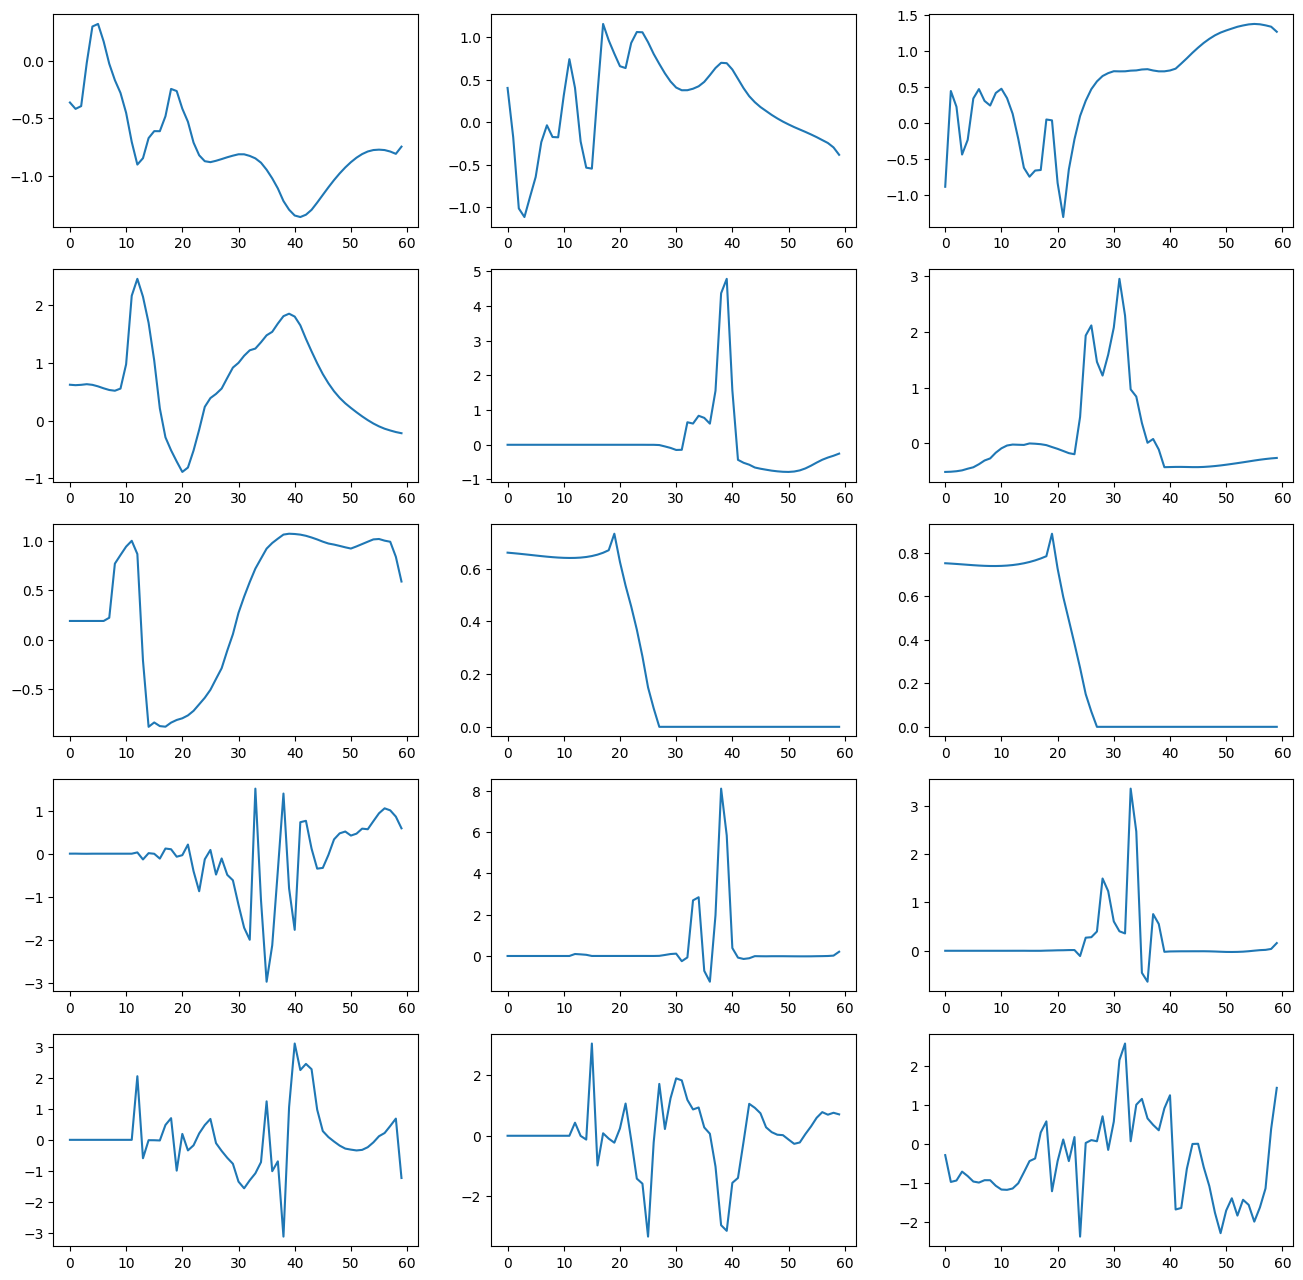

In [48]:
X_point, y_point = X[8], y[8] # nth data point from batch

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16, 16))

axes[0, 0].plot(X_point[STATE_U_IDX])
axes[0, 1].plot(X_point[STATE_V_IDX])
axes[0, 2].plot(X_point[STATE_T_IDX])

axes[1, 0].plot(X_point[STATE_Q0001_IDX])
axes[1, 1].plot(X_point[STATE_Q0002_IDX])
axes[1, 2].plot(X_point[STATE_Q0003_IDX])

axes[2, 0].plot(X_point[PBUF_OZONE_IDX])
axes[2, 1].plot(X_point[PBUF_CH4_IDX])
axes[2, 2].plot(X_point[PBUF_N2O_IDX])

axes[3, 0].plot(y_point[PTEND_Q0001_IDX])
axes[3, 1].plot(y_point[PTEND_Q0002_IDX])
axes[3, 2].plot(y_point[PTEND_Q0003_IDX])

axes[4, 0].plot(y_point[PTEND_U_IDX])
axes[4, 1].plot(y_point[PTEND_V_IDX])
axes[4, 2].plot(y_point[PTEND_T_IDX])

plt.show()

### Training

In [49]:
LOSS_SCALE_TORCH = torch.tensor(LOSS_SCALE, dtype = torch.float64).to(DEVICE) * torch.tensor(TARGET_WEIGHTS, dtype = torch.float64).to(DEVICE)

In [50]:
def WeightedMSE(y_pred, y):
    return (LOSS_SCALE_TORCH**2 * (y - y_pred) ** 2)

In [51]:
a = torch.rand([2000, 368]).to(DEVICE)
b = torch.rand([2000, 368]).to(DEVICE)
print(WeightedMSE(a, b).mean())
print(WeightedMSE(a, b).mean(0).sum()/a.shape[-1])

tensor(0.1329, device='cuda:0', dtype=torch.float64)
tensor(0.1329, device='cuda:0', dtype=torch.float64)


In [52]:
#model = LeapModel(**nn_config)
model = TfaLeapModel(**nn_config_tfa)
model = model.to(DEVICE)
#model.load_state_dict(torch.load("best_mse_model.pth", map_location=DEVICE))


criterion = nn.MSELoss()
criterion = WeightedMSE
#criterion = torch.nn.HuberLoss(reduction='mean', delta=5.0)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.PolynomialLR(optimizer, power=1.0, total_iters=NUM_EPOCHS)

In [53]:
# scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
#             optimizer,
#             T_0=NUM_EPOCHS,
#             T_mult=1,
#             eta_min=1e-7,
#             last_epoch=-1
#         )

In [54]:
# lrs = []
# for i in range(NUM_EPOCHS):
#     scheduler.step(i)
#     lrs.append(scheduler.get_lr())

In [55]:
#plt.plot(list(range(NUM_EPOCHS)), lrs)

In [56]:
best_score = -np.inf
best_mse = np.inf

scores = []
mses = []
r2s = []
train_mse = []

for epoch in range(0, NUM_EPOCHS):
    train_loss = train_fn(model, train_loader, optimizer, criterion)
    val_score, val_mse, val_r2_full = valid_fn(model, valid_loader)

    train_mse.append(train_loss)
    scores.append(val_score)
    mses.append(val_mse)   
    r2s.append(val_r2_full)   
    
    if val_r2_full > best_score:
        best_score = val_r2_full
        torch.save(model.state_dict(), "best_score_model.pth")

    if val_mse < best_mse:
        best_mse = val_mse
        torch.save(model.state_dict(), "best_mse_model.pth")
        
    torch.save(model.state_dict(), "last_model.pth")
    
    scheduler.step()

Epoch 3:  35%|███████████▍                     | 1698/4882 [03:55<07:20,  7.22it/s, train_loss=1.44]


KeyboardInterrupt: 

In [ ]:
history = pd.DataFrame({'train_loss': train_mse, 'mse': mses, 'r2': r2s})

In [ ]:
history.plot()

In [ ]:
#val_score, val_mse, val_r2_full = valid_fn(model, valid_loader)

In [ ]:
#torch.cuda.empty_cache()

# Pred val set

In [ ]:
model = TfaLeapModel(**nn_config_tfa)
model = model.to(DEVICE)
model.load_state_dict(torch.load("best_score_model.pth", map_location=DEVICE))

In [57]:
def predict_valid(model: nn.Module, loader: DataLoader) -> float:
    """
    Validate the deep learning model for 1 epoch.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to be validated.
    loader : torch.utils.data.DataLoader
        DataLoader for the validation data.

    Returns
    -------
    float
        The average R2 score over the validation epoch.
    """
    
    progress_bar = tqdm(enumerate(loader, start=1), total=len(loader), ncols=100)
    #progress_bar.set_description(f'Epoch {epoch}')
    model.eval()
    val_score = 0
    preds = []
    
    with torch.no_grad():
        for step, batch in progress_bar:
            x, y = batch
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            y_pred = model(x)['output']
            
            y = y.cpu()
            y = (y * Y_STD) + Y_MEAN
            #y = (y * Y_STD)
            y /= torch.tensor(SCALE_WEIGHTS)

            
            y_pred = y_pred.cpu()
            #y_pred[:, Y_STD == 0] = Y_MEAN[:, Y_STD == 0]
            #y_pred[:, Y_STD < (1.1 * ERR)] = Y_MEAN[Y_STD < (1.1 * ERR)]
            
            y_pred = (y_pred * Y_STD) + Y_MEAN
            #y_pred = (y_pred * Y_STD) 
            y_pred /= torch.tensor(SCALE_WEIGHTS)

            
            val_score += r2_score(y_pred, y)
            
            progress_bar.set_postfix({
                'valid_score': val_score / step,
            })
        
            preds.append(y_pred.numpy())
    return np.vstack(preds)

In [58]:
#y_valid = np.concatenate([((yb * Y_STD))/torch.tensor(SCALE_WEIGHTS) for _, yb in valid_loader])
y_valid = np.concatenate([((yb * Y_STD) + Y_MEAN)/torch.tensor(SCALE_WEIGHTS) for _, yb in valid_loader])
#y_valid = np.concatenate([((yb * Y_STD) + Y_MEAN) for _, yb in valid_loader])
#x_valid = np.concatenate([xb for xb, _ in valid_loader])
p_valid = predict_valid(model, valid_loader)

100%|██████████████████████████████████████████| 977/977 [00:59<00:00, 16.56it/s, valid_score=0.981]


In [ ]:
(~np.isfinite(y_valid)).sum()

In [ ]:
plt.plot(y_valid.max(0)[:368])

In [ ]:
plt.plot(p_valid.max(0)[:368])

In [ ]:
p_valid.max(0)[359:]

In [ ]:
Y_MEAN[359:]

In [59]:
(nn.MSELoss(reduction='none')(torch.tensor(p_valid), torch.tensor(y_valid)) * torch.tensor(TARGET_WEIGHTS)).sum(1).mean()

tensor(4816.4121, dtype=torch.float64)

In [60]:
r2_score_clipped(torch.tensor(p_valid), torch.tensor(y_valid))

0.5108515928661971

In [61]:
errors = (((p_valid - y_valid)**2)**0.5/368).sum(1)
top_mistakes = (-errors).argsort()

errors[top_mistakes]

array([3.28192886, 3.04088385, 2.94559802, ..., 0.01000361, 0.00915112,
       0.00710985])

In [62]:
mask_errors = errors[top_mistakes] > 1.0
mask_errors.sum()

5289

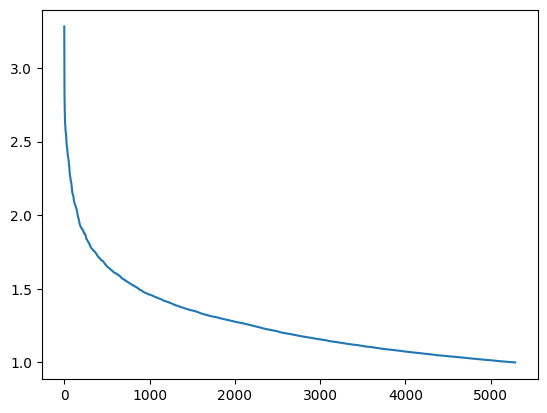

In [63]:
plt.plot(errors[top_mistakes][mask_errors])

0.5108515928661971

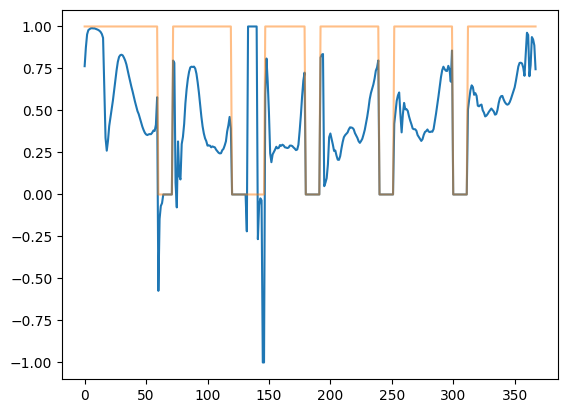

In [64]:


scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(368)]) 
plt.plot(scores_valid.clip(-1, 1))
plt.plot(TARGET_WEIGHTS, alpha = 0.5)
(scores_valid.clip(-1, 1) * np.array(TARGET_WEIGHTS)).sum() / np.array(TARGET_WEIGHTS).sum()

In [68]:
y_valid_scale = (y_valid - Y_MEAN.numpy()) / Y_STD.numpy()
p_valid_scale = (p_valid - Y_MEAN.numpy()) / Y_STD.numpy()

0.510851592861796

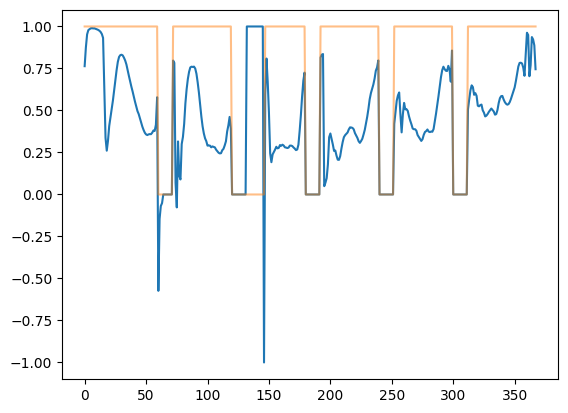

In [69]:
scores_valid = np.array([metrics.r2_score(y_valid_scale[:, i], p_valid_scale[:, i]) for i in range(368)]) 
plt.plot(scores_valid.clip(-1, 1))
plt.plot(TARGET_WEIGHTS, alpha = 0.5)
(scores_valid.clip(-1, 1) * np.array(TARGET_WEIGHTS)).sum() / np.array(TARGET_WEIGHTS).sum()

0.5111141074445446

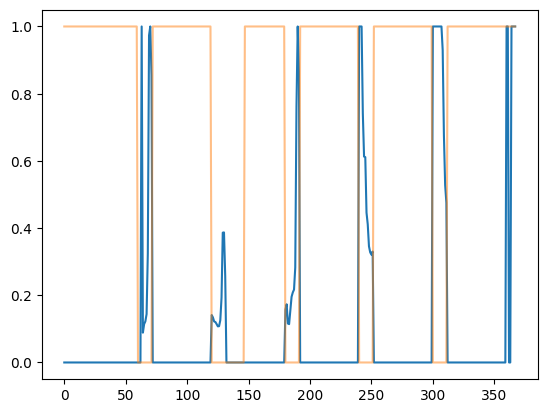

In [83]:
mse_valid = nn.MSELoss(reduction='none')(torch.tensor(y_valid_scale), torch.tensor(p_valid_scale)).mean(0).numpy()

plt.plot(mse_valid.clip(0, 1))
plt.plot(TARGET_WEIGHTS, alpha = 0.5)
(scores_valid.clip(0, 1) * np.array(TARGET_WEIGHTS)).sum() / np.array(TARGET_WEIGHTS).sum()

In [82]:
LOSS_SCALE_TORCH

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [90]:
mse_valid

array([2.09506238e-09, 1.04994408e-09, 4.66432340e-10, 2.17600341e-10,
       1.59169645e-10, 1.11864461e-10, 1.04262274e-10, 1.14963246e-10,
       1.14338933e-10, 1.41726732e-10, 1.70966227e-12, 2.03381648e-12,
       2.53061821e-12, 3.25249860e-12, 4.47536344e-12, 6.68854718e-12,
       4.40233240e-11, 7.89369747e-09, 7.51170801e-09, 6.78574385e-09,
       5.91708115e-09, 5.17046257e-09, 4.65655523e-09, 4.05301157e-09,
       3.43751308e-09, 2.97467509e-09, 2.46586760e-09, 2.03588684e-09,
       1.75871473e-09, 1.68970783e-09, 1.67764342e-09, 1.72036672e-09,
       1.84409683e-09, 2.00872023e-09, 2.23702285e-09, 2.58185963e-09,
       2.89865976e-09, 3.19511882e-09, 3.54143021e-09, 3.83642835e-09,
       4.16362021e-09, 4.46330435e-09, 4.73666436e-09, 4.98634823e-09,
       5.18193491e-09, 5.45291144e-09, 5.73542818e-09, 5.95268960e-09,
       6.12743237e-09, 6.28552661e-09, 6.40890789e-09, 6.40772875e-09,
       6.35895824e-09, 6.33195396e-09, 6.35610804e-09, 6.36778156e-09,
      

In [92]:
LOSS_SCALE_TORCH[[-1,-2,-3,-4,-7,-8]] = 0.1

In [93]:
LOSS_SCALE_TORCH

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

0.5111141074445446

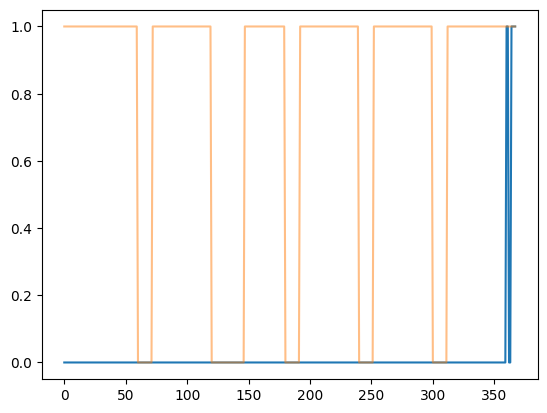

In [79]:
mse_valid = nn.MSELoss(reduction='none')(torch.tensor(y_valid), torch.tensor(p_valid)).mean(0).numpy()

plt.plot(mse_valid.clip(0, 1))
plt.plot(TARGET_WEIGHTS, alpha = 0.5)
(scores_valid.clip(0, 1) * np.array(TARGET_WEIGHTS)).sum() / np.array(TARGET_WEIGHTS).sum()

In [ ]:
scores_valid = np.array([metrics.mean_absolute_percentage_error(y_valid[:, i], p_valid[:, i]) for i in range(368)]) 
plt.plot(scores_valid.clip(0, 300))
plt.plot(np.array(TARGET_WEIGHTS)*100, alpha = 0.5)
(scores_valid.clip(-1, 1) * np.array(TARGET_WEIGHTS)).sum() / np.array(TARGET_WEIGHTS).sum()

In [ ]:
y_valid

In [ ]:
plt.plot(scores_valid.clip(-1, 1)[80:110])

In [ ]:
Y_STD[70:110]

In [ ]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0][Y_STD[np.array(TARGET_WEIGHTS)>0] == 0]

In [ ]:
scores_valid[Y_MEAN==0]

In [ ]:
Y_STD[np.array(TARGET_WEIGHTS)>0]

In [ ]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0]

In [ ]:
Y_MEAN

In [ ]:
import math

S_WEIGHTS = []

for val in Y_MEAN:
    if val != 0:
        logval = math.log10(abs(val))
        S_WEIGHTS.append(-round(logval - (0.5 if logval<0 else 0)))
    else:
        S_WEIGHTS.append(0)


S_WEIGHTS = [float(f'1e{f}') for f in S_WEIGHTS]

In [ ]:
print(S_WEIGHTS)

In [ ]:
round(logval - (0.5 if logval<0 else 0))

In [ ]:
S_WEIGHTS = []

for yy in Y_MEAN:
    T = 1
    if abs(yy) > 1:
        T = 1   
    elif abs(yy) > 1e-6:
        T = 1e6
    elif abs(yy) > 1e-10:
        T = 1e10    
    elif abs(yy) > 1e-16:
        T = 1e16            
    elif abs(yy) > 1e-20:
        T = 1e20        
    elif abs(yy) > 1e-24:
        T = 1e24        
    elif abs(yy) > 1e-30:
        T = 1e30
    elif abs(yy) > 1e-36:
        T = 1e36
    elif abs(yy) <= 1e-36:
        T = 1e36
    S_WEIGHTS.append(T)
                    

In [ ]:
print(S_WEIGHTS)

In [ ]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0][Y_STD[np.array(TARGET_WEIGHTS)>0] == ERR]

In [ ]:
Y_STD[np.array(TARGET_WEIGHTS)>0]

In [ ]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0]

In [ ]:
[Y_STD[np.array(TARGET_WEIGHTS)>0] == ERR]

In [ ]:
np.log(6.8322e-37)

In [ ]:
Y_MEAN

In [ ]:
np.finfo(np.float32)

In [ ]:
Y_STD[np.array(TARGET_WEIGHTS)>0]

In [ ]:
mask = scores_valid <= 1e-3

p_test = np.array(p_valid)
p_test[:, mask] = Y_MEAN[mask]

In [ ]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_test[:, i]) for i in range(368)])
plt.plot(scores_valid.clip(-1, 1))
plt.plot(TARGET_WEIGHTS, alpha = 0.5)
scores_valid.clip(-1, 1).mean()

### Evaluation

In [ ]:
model = LeapModel(**nn_config)
model = model.to(DEVICE)
model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
#model.load_state_dict(torch.load("/kaggle/input/leap-models/first_leap_model.pth", map_location=DEVICE))

df_test = pl.read_csv(TEST_PATH)
df_test = df_test.to_pandas()
df_test = df_test.set_index("sample_id")

df_subm = pl.read_csv(SUBMISSION_PATH)
df_subm = df_subm.to_pandas()
df_subm = df_subm.set_index("sample_id")

static_pred = -df_test[REPLACE_TO].to_numpy() * df_subm[REPLACE_FROM].to_numpy() / 1200

In [ ]:
df_subm.loc[df_test.index, TARGET_NAMES] = pred_fn(model, df_test)

df_subm[REPLACE_FROM] = static_pred

df_subm = df_subm.reset_index()
df_subm = df_subm[["sample_id"] + TARGET_NAMES]

df_subm = pl.from_pandas(df_subm)
df_subm.write_csv("submission.csv")

In [ ]:
import pandas as pd

df = pd.concat([
    pd.read_parquet('train_data_sample_3kk_part_1.parquet'),
    pd.read_parquet('train_data_sample_3kk_part_2.parquet')]
              )

